In [1]:
#FUNCTION TO CLEAN A SINGLE DF
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import datetime
import os

col_names = ["Index", "DateD", "DateM", "DateY", "Time", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused", "Light"]

for i in range(1, 33):
    col_names.append(f"Sp{i}")

file = 'Steatoda B masking 04pm.txt'

df = pd.read_csv(file, names=col_names, sep='\s+', header=None)
df = df.set_index('Index')
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')
df = df[df["MonStatus"] == 1]


month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6}
df['DateM'] = df['DateM'].str[:3].map(month_map)
df['DateY'] = df['DateY'].apply(lambda x: int(str(20) + str(x)))
df['Date'] = pd.to_datetime(dict(year=df['DateY'], month=df['DateM'], day=df['DateD']), errors='coerce')

df['Time'] = pd.to_datetime(dict(year=df['Date'].dt.year,
                                     month=df['Date'].dt.month,
                                     day=df['Date'].dt.day,
                                     hour=df['Time'].dt.hour,
                                     minute=df['Time'].dt.minute,
                                     second=df['Time'].dt.second))

df = df.drop(["DateD", "DateM", "DateY", "Date", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused"], axis=1)

day_map = {day: idx+1 for idx, day in enumerate(df['Time'].dt.day.unique())}

df.insert(0, 'Day', df['Time'].dt.day.map(day_map))

#df.to_csv('steatodaA.csv')

#FUNCTION TO FILTER THRESHOLD ON A SINGLE FILE
import pandas as pd

def filter_and_merge(df, threshold=0):
    additional_columns = df.columns[:3]
    filtered_dfs = []

    for day in range(1, 9):  
        day_df = df[df['Day'] == day] 
        count_mov = day_df.filter(like="Sp")  
        x = count_mov.sum(axis=0)  
        z = x > threshold  
        columns_to_keep = z[z].index 
        
        all_columns_to_keep = list(additional_columns) + list(columns_to_keep)
        filtered_df = day_df[all_columns_to_keep]
        filtered_dfs.append(filtered_df)

    merged_df = pd.concat(filtered_dfs)
    merged_df1 = merged_df.dropna(axis=1)
    
    return merged_df1
    
merged_df = filter_and_merge(df)

#CODE TO TEST FOR ENTRAINMENT
import numpy as np

def entrainment(data, column):
    if column not in data.columns:
        return False
    
    dflight = data[data['Light'] == 1][column]
    dfdark = data[data['Light'] == 0][column]
    
    lightmean = np.mean(dflight)
    darkmean = np.mean(dfdark)
    
    if darkmean == 0:
        return False
    
    diff = lightmean / darkmean
    return diff > 0.25

spiders = ["Sp"+str(i) for i in range(1, 33)]

entrainment_results = []

for spider_column in spiders:
    if spider_column in merged_df.columns:  # Check if the column exists
        entrainment_result = entrainment(merged_df, spider_column)
        entrainment_results.append((spider_column, entrainment_result))

results_df = pd.DataFrame(entrainment_results, columns=['Spider', 'Entrained'])

entrained_spiders = results_df[results_df['Entrained'] == True]['Spider'].tolist()

#CODE TO FILTER ENTRAINMENT
finaldf = []

additional_columns = merged_df.columns[:3]
columns_to_keep = entrained_spiders
        
all_columns_to_keep = list(additional_columns) + list(columns_to_keep)
filtered_df = merged_df[all_columns_to_keep]  # Use merged_df here, not entrained_spiders

finaldf.append(filtered_df)

merged_dfx = pd.concat(finaldf)
merged_dfx1 = merged_dfx.dropna(axis=1)  # Use merged_dfx here, not merged_df

display(merged_dfx1)

,Day,Time,Light,Sp3,Sp4,Sp7,Sp9,Sp11,Sp12,Sp13,Sp14,Sp15,Sp17,Sp19,Sp21
Index,,,,,,,,,,,,,,,
14,1,2024-04-17 15:56:00,1,0,16,2,0,0,26,0,0,0,0,2,0
15,1,2024-04-17 15:57:00,1,0,8,3,0,0,17,0,0,0,0,1,0
16,1,2024-04-17 15:58:00,1,0,8,4,0,0,19,0,0,0,0,6,0
17,1,2024-04-17 15:59:00,1,0,15,2,0,0,11,0,0,0,0,1,0
18,1,2024-04-17 16:00:00,1,0,9,2,0,0,14,6,0,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10036,8,2024-04-24 14:58:00,1,0,0,0,0,0,0,0,0,0,0,0,0
10037,8,2024-04-24 14:59:00,1,0,0,0,0,0,0,0,0,0,0,0,0
10038,8,2024-04-24 15:00:00,1,0,0,0,0,0,0,0,0,0,0,0,0


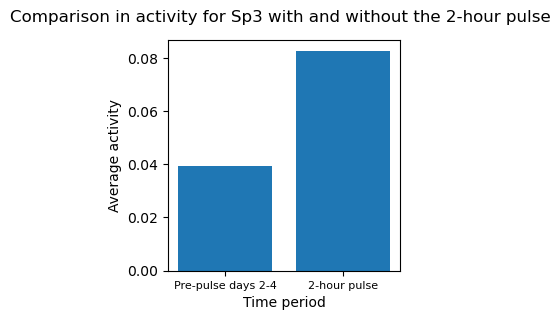

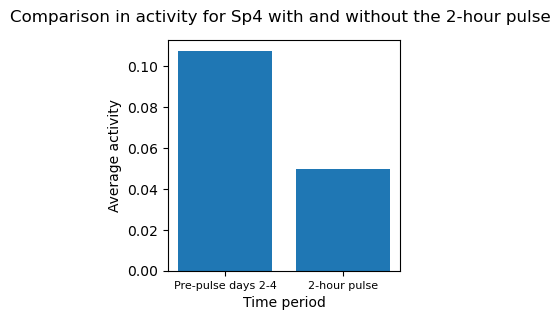

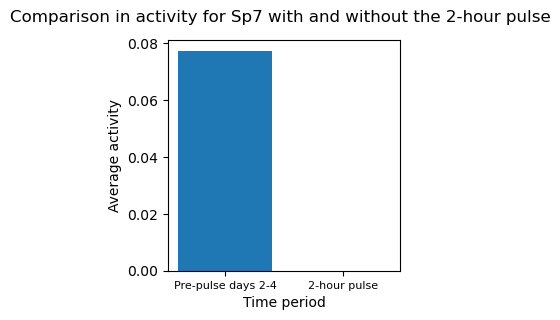

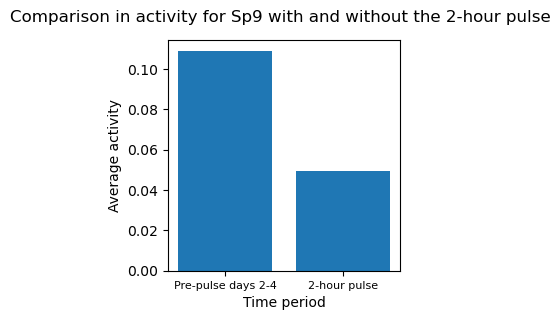

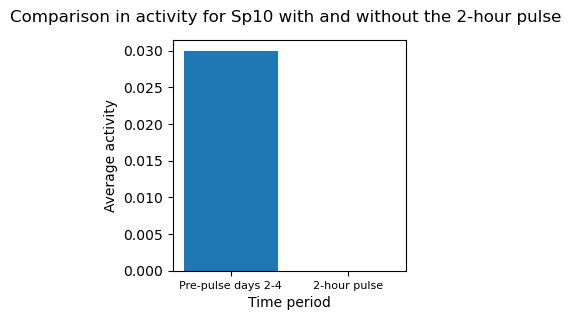

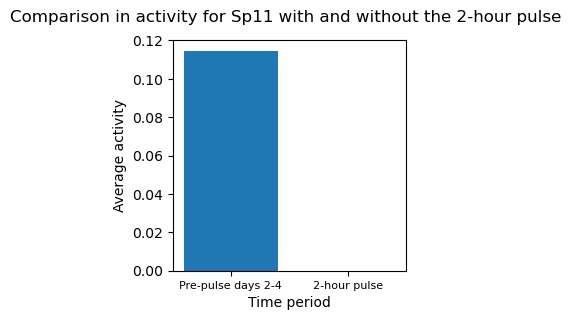

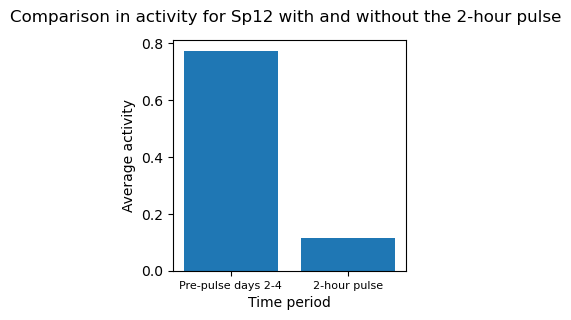

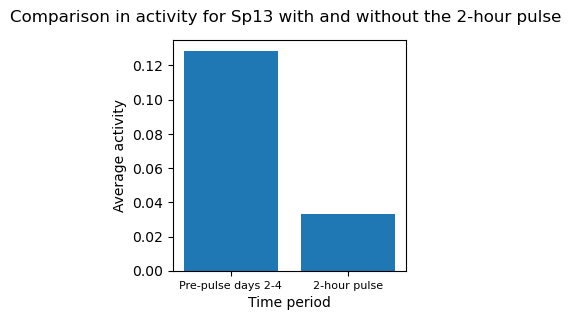

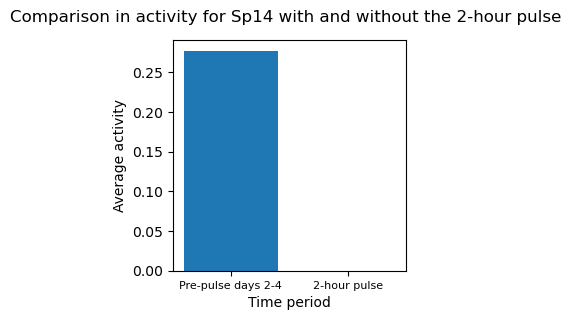

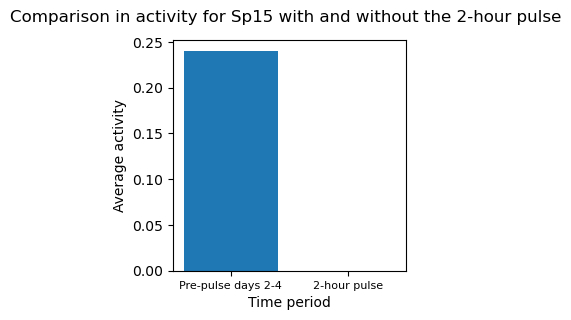

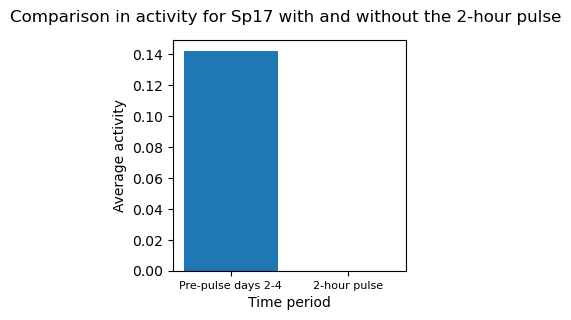

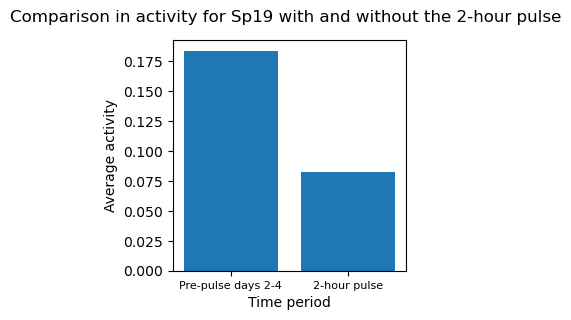

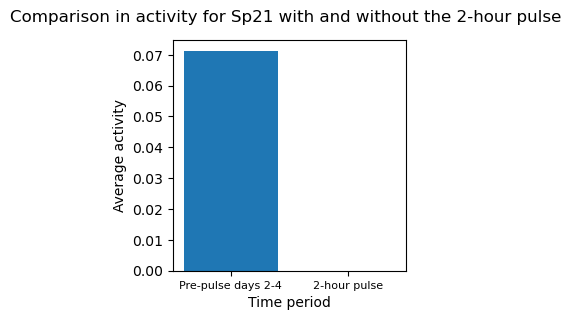

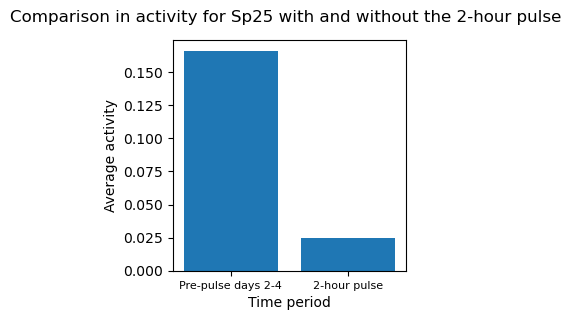

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

def filter_and_compare_activity(df, day_pulse, day_pre_pulse, start_hour, end_hour):
    # Define the range of days for the pre-pulse period
    pre_pulse_days = [2, 3, 4]

    # Get the unique dates for the specified days
    pre_pulse_dates = df.loc[df['Day'].isin(pre_pulse_days), 'Time'].dt.date.unique()
    pulse_date = df.loc[df['Day'] == day_pulse, 'Time'].dt.date.unique()[0]
    
    # Construct start and end times with the correct dates
    start_time_pre_pulse = pd.to_datetime(f"{pre_pulse_dates[0]} {start_hour}")
    end_time_pre_pulse = pd.to_datetime(f"{pre_pulse_dates[-1]} {end_hour}")
    start_time_pulse = pd.to_datetime(f"{pulse_date} {start_hour}")
    end_time_pulse = pd.to_datetime(f"{pulse_date} {end_hour}")
    
    # Filter the days
    days_pre_pulse = df.loc[df['Day'].isin(pre_pulse_days)]
    day_pulse = df.loc[df['Day'] == day_pulse]
    
    # Filter the time range for the specified days
    day_pre_pulse_filtered = days_pre_pulse[(days_pre_pulse['Time'] >= start_time_pre_pulse) & (days_pre_pulse['Time'] <= end_time_pre_pulse)]
    day_pulse_filtered = day_pulse[(day_pulse['Time'] >= start_time_pulse) & (day_pulse['Time'] <= end_time_pulse)]
    
    for spider_col in df.columns:
        if spider_col.startswith('Sp'):
            # Calculate the mean activity for each spider column
            mean_day_pre_pulse = day_pre_pulse_filtered[spider_col].mean()
            mean_day_pulse = day_pulse_filtered[spider_col].mean()
            
            # Plot the results
            plt.figure(figsize=(3, 3))
            plt.bar(['Pre-pulse days 2-4', '2-hour pulse'], [mean_day_pre_pulse, mean_day_pulse])
            plt.suptitle(f'Comparison in activity for {spider_col} with and without the 2-hour pulse', fontsize=12)
            plt.ylabel('Average activity', fontsize=10)
            plt.xlabel('Time period', fontsize=10)
            plt.xticks(fontsize=8)
            plt.show()

# Example usage
day_pulse = 5 
day_pre_pulse = 4  
start_hour = '16:00:00' 
end_hour = '18:00:00'  

# Ensure 'Time' is in datetime format
merged_df['Time'] = pd.to_datetime(merged_df['Time'])

filter_and_compare_activity(merged_df, day_pulse, day_pre_pulse, start_hour, end_hour)

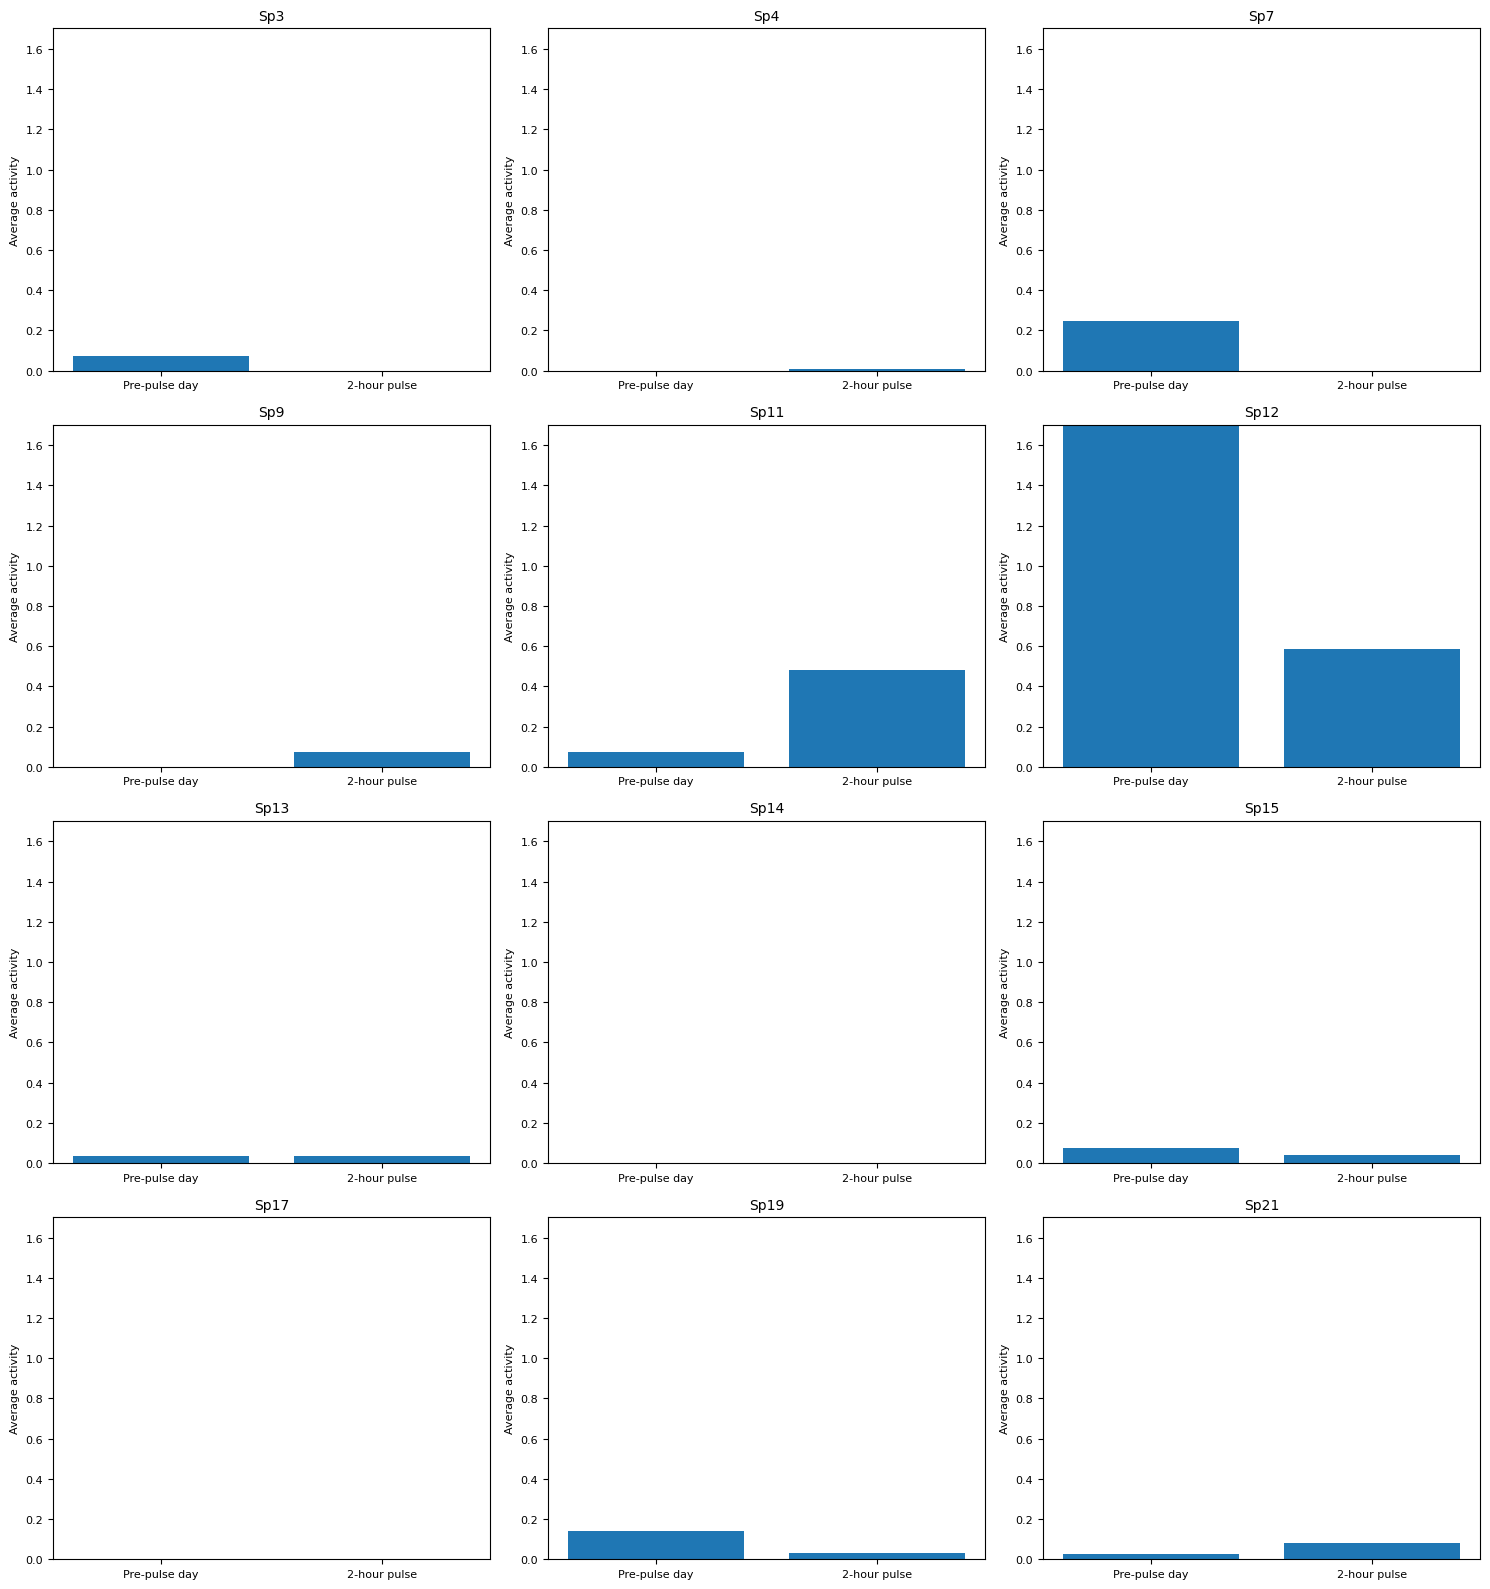

   Spider  Mean Pre-pulse Activity  Mean Pulse Activity
0     Sp3                 0.074380             0.000000
1     Sp4                 0.000000             0.008264
2     Sp7                 0.247934             0.000000
3     Sp9                 0.000000             0.074380
4    Sp11                 0.074380             0.479339
5    Sp12                 1.702479             0.586777
6    Sp13                 0.033058             0.033058
7    Sp14                 0.000000             0.000000
8    Sp15                 0.074380             0.041322
9    Sp17                 0.000000             0.000000
10   Sp19                 0.140496             0.033058
11   Sp21                 0.024793             0.082645


In [3]:
#FUNCTION FOR PLOTTING ALL SPIDERS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def filter_and_compare_activity(df, day_pulse, day_pre_pulse, start_hour, end_hour):
    # Get the unique dates for the specified days
    pre_pulse_date = df.loc[df['Day'] == day_pre_pulse, 'Time'].dt.date.unique()[0]
    pulse_date = df.loc[df['Day'] == day_pulse, 'Time'].dt.date.unique()[0]
    
    # Construct start and end times with the correct dates
    start_time_pre_pulse = pd.to_datetime(f"{pre_pulse_date} {start_hour}")
    end_time_pre_pulse = pd.to_datetime(f"{pre_pulse_date} {end_hour}")
    start_time_pulse = pd.to_datetime(f"{pulse_date} {start_hour}")
    end_time_pulse = pd.to_datetime(f"{pulse_date} {end_hour}")
    
    # Filter the days
    day_pre = df.loc[df['Day'] == day_pre_pulse]
    day_pulse = df.loc[df['Day'] == day_pulse]
    
    # Filter the time range for the specified days
    day_pre_filtered = day_pre[(day_pre['Time'] >= start_time_pre_pulse) & (day_pre['Time'] <= end_time_pre_pulse)]
    day_pulse_filtered = day_pulse[(day_pulse['Time'] >= start_time_pulse) & (day_pulse['Time'] <= end_time_pulse)]
    
    # Initialize a list to store mean activity data for each spider
    spider_means = []
    
    # Loop through each spider column
    spider_columns = [col for col in df.columns if col.startswith('Sp')]
    
    # Calculate the number of rows and columns for the grid
    num_spiders = len(spider_columns)
    num_cols = 3  # You can adjust this value based on how many columns you want in the grid
    num_rows = (num_spiders + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
    axes = axes.flatten()  # Flatten the axes array to easily index it
    
    for idx, spider_col in enumerate(spider_columns):
        # Filter for the specific spider column
        spider_day_pre = day_pre_filtered[spider_col]
        spider_day_pulse = day_pulse_filtered[spider_col]
        
        # Calculate the mean activity
        mean_day_pre = spider_day_pre.mean()
        mean_day_pulse = spider_day_pulse.mean()
        
        # Append the results to the spider_means list
        spider_means.append((spider_col, mean_day_pre, mean_day_pulse))
        
        # Plot the results for each spider in the grid
        ax = axes[idx]
        days = ['Pre-pulse day', '2-hour pulse']
        means = [mean_day_pre, mean_day_pulse]
        
        ax.bar(days, means)
        ax.set_title(f'{spider_col}', fontsize=10)
        ax.set_ylabel('Average activity', fontsize=8)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(days, fontsize=8)
        ax.tick_params(axis='y', labelsize=8)
    
    # Remove any empty subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Find the maximum mean activity across all spiders
    max_mean_activity = max([mean for _, mean_pre, mean_pulse in spider_means for mean in (mean_pre, mean_pulse)])
    
    # Set the same y-axis range for all subplots
    for ax in axes:
        ax.set_ylim(0, max_mean_activity)
    
    plt.tight_layout()
    plt.show()
    
    # Create a DataFrame to store the means for all spiders
    means_df = pd.DataFrame(spider_means, columns=['Spider', 'Mean Pre-pulse Activity', 'Mean Pulse Activity'])
    
    return means_df

# Example usage
# Define the parameters
day_pulse = 5  # The day when the pulse occurred
day_pre_pulse = 4  # The day before the pulse
start_hour = '16:00:00'  # Replace with the desired start hour
end_hour = '18:00:00'  # Replace with the desired end hour

# Ensure 'Time' is in datetime format
merged_dfx1['Time'] = pd.to_datetime(merged_dfx1['Time'])

# Call the function using the existing df
means_df = filter_and_compare_activity(merged_dfx1, day_pulse, day_pre_pulse, start_hour, end_hour)
print(means_df)

In [4]:
#TRYING TO GET IT ALL TOGETHER SO I CAN PLOT FOR ALL AT ONCE?



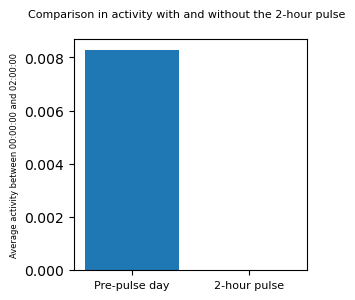

In [5]:
#FUNCTION FOR PLOTTING
import pandas as pd
import matplotlib.pyplot as plt

def filter_and_compare_activity(df, spider_col, day_pulse, day_pre_pulse, start_hour, end_hour):
    pre_pulse_date = df.loc[df['Day'] == day_pre_pulse, 'Time'].dt.date.unique()[0]
    pulse_date = df.loc[df['Day'] == day_pulse, 'Time'].dt.date.unique()[0]
    
    start_time_pre_pulse = pd.to_datetime(f"{pre_pulse_date} {start_hour}")
    end_time_pre_pulse = pd.to_datetime(f"{pre_pulse_date} {end_hour}")
    start_time_pulse = pd.to_datetime(f"{pulse_date} {start_hour}")
    end_time_pulse = pd.to_datetime(f"{pulse_date} {end_hour}")
    
    day_pre = df.loc[df['Day'] == day_pre_pulse]
    day_pulse = df.loc[df['Day'] == day_pulse]
    
    day_pre_filtered = day_pre[(day_pre['Time'] >= start_time_pre_pulse) & (day_pre['Time'] <= end_time_pre_pulse)]
    day_pulse_filtered = day_pulse[(day_pulse['Time'] >= start_time_pulse) & (day_pulse['Time'] <= end_time_pulse)]
    
    spider_day_pre = day_pre_filtered[spider_col]
    spider_day_pulse = day_pulse_filtered[spider_col]
    
    mean_day_pre = spider_day_pre.mean()
    mean_day_pulse = spider_day_pulse.mean()
    
    means_df = pd.DataFrame({
        'Day': ['Pre-pulse day', '2-hour pulse'],
        'Mean Activity': [mean_day_pre, mean_day_pulse]
    })
    
    # Plot the results
    plt.figure(figsize=(3, 3))
    plt.bar(means_df['Day'], means_df['Mean Activity'])
    plt.suptitle('Comparison in activity with and without the 2-hour pulse', fontsize=8)
    plt.ylabel('Average activity between {} and {}'.format(start_hour, end_hour), fontsize=6)
    plt.xticks(fontsize=8)
    plt.show()
    
    return means_df

spider_col = 'Sp15'  
day_pulse = 5 
day_pre_pulse = 4  
start_hour = '16:00:00' 
end_hour = '18:00:00'  

merged_df['Time'] = pd.to_datetime(merged_df['Time'])

means_df = filter_and_compare_activity(merged_df, spider_col, day_pulse, day_pre_pulse, start_hour, end_hour)

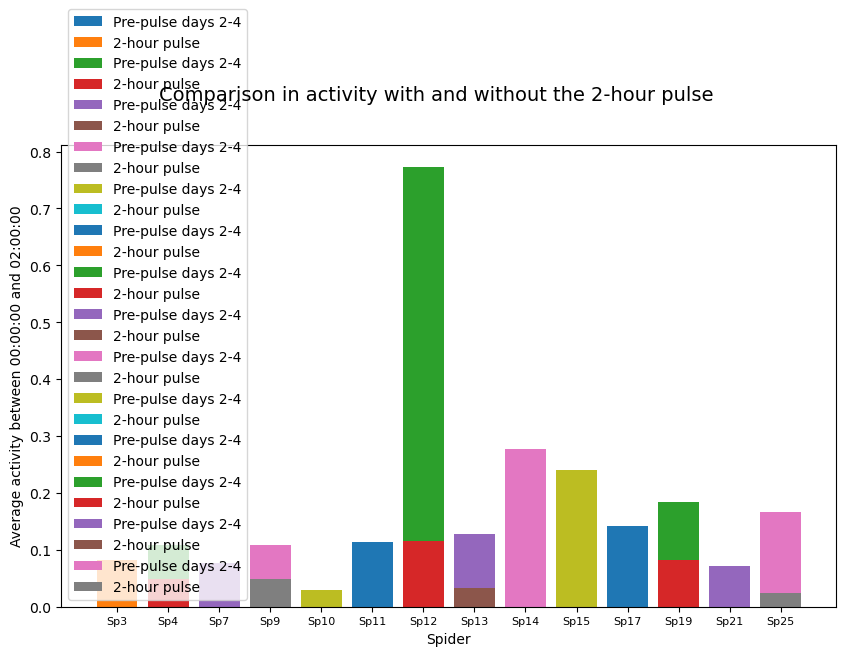

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

def filter_and_compare_activity(df, day_pulse, day_pre_pulse, start_hour, end_hour):
    # Define the range of days for the pre-pulse period
    pre_pulse_days = [2, 3, 4]

    # Get the unique dates for the specified days
    pre_pulse_dates = df.loc[df['Day'].isin(pre_pulse_days), 'Time'].dt.date.unique()
    pulse_date = df.loc[df['Day'] == day_pulse, 'Time'].dt.date.unique()[0]
    
    # Construct start and end times with the correct dates
    start_time_pre_pulse = pd.to_datetime(f"{pre_pulse_dates[0]} {start_hour}")
    end_time_pre_pulse = pd.to_datetime(f"{pre_pulse_dates[-1]} {end_hour}")
    start_time_pulse = pd.to_datetime(f"{pulse_date} {start_hour}")
    end_time_pulse = pd.to_datetime(f"{pulse_date} {end_hour}")
    
    # Filter the days
    days_pre_pulse = df.loc[df['Day'].isin(pre_pulse_days)]
    day_pulse = df.loc[df['Day'] == day_pulse]
    
    # Filter the time range for the specified days
    day_pre_pulse_filtered = days_pre_pulse[(days_pre_pulse['Time'] >= start_time_pre_pulse) & (days_pre_pulse['Time'] <= end_time_pre_pulse)]
    day_pulse_filtered = day_pulse[(day_pulse['Time'] >= start_time_pulse) & (day_pulse['Time'] <= end_time_pulse)]
    
    means = []
    for spider_col in df.columns:
        if spider_col.startswith('Sp'):
            # Calculate the mean activity for each spider column
            mean_day_pre_pulse = day_pre_pulse_filtered[spider_col].mean()
            mean_day_pulse = day_pulse_filtered[spider_col].mean()
            
            means.append({
                'Spider': spider_col,
                'Pre-pulse days 2-4': mean_day_pre_pulse,
                '2-hour pulse': mean_day_pulse
            })
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    for spider_data in means:
        plt.bar(spider_data['Spider'], spider_data['Pre-pulse days 2-4'], label='Pre-pulse days 2-4')
        plt.bar(spider_data['Spider'], spider_data['2-hour pulse'], label='2-hour pulse')
    plt.suptitle('Comparison in activity with and without the 2-hour pulse', fontsize=14)
    plt.ylabel('Average activity between {} and {}'.format(start_hour, end_hour), fontsize=10)
    plt.xlabel('Spider', fontsize=10)
    plt.xticks(fontsize=8)
    plt.legend()
    plt.show()
    
    return pd.DataFrame(means)

# Example usage
day_pulse = 5 
day_pre_pulse = 4  
start_hour = '16:00:00' 
end_hour = '18:00:00'  

# Ensure 'Time' is in datetime format
merged_df['Time'] = pd.to_datetime(merged_df['Time'])

means_df = filter_and_compare_activity(merged_df, day_pulse, day_pre_pulse, start_hour, end_hour)

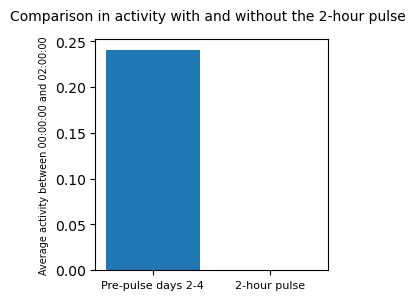

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

def filter_and_compare_activity(df, spider_col, day_pulse, day_pre_pulse, start_hour, end_hour):
    # Define the range of days for the pre-pulse period
    pre_pulse_days = [2, 3, 4]

    # Get the unique dates for the specified days
    pre_pulse_dates = df.loc[df['Day'].isin(pre_pulse_days), 'Time'].dt.date.unique()
    pulse_date = df.loc[df['Day'] == day_pulse, 'Time'].dt.date.unique()[0]
    
    # Construct start and end times with the correct dates
    start_time_pre_pulse = pd.to_datetime(f"{pre_pulse_dates[0]} {start_hour}")
    end_time_pre_pulse = pd.to_datetime(f"{pre_pulse_dates[-1]} {end_hour}")
    start_time_pulse = pd.to_datetime(f"{pulse_date} {start_hour}")
    end_time_pulse = pd.to_datetime(f"{pulse_date} {end_hour}")
    
    # Filter the days
    days_pre_pulse = df.loc[df['Day'].isin(pre_pulse_days)]
    day_pulse = df.loc[df['Day'] == day_pulse]
    
    # Filter the time range for the specified days
    day_pre_pulse_filtered = days_pre_pulse[(days_pre_pulse['Time'] >= start_time_pre_pulse) & (days_pre_pulse['Time'] <= end_time_pre_pulse)]
    day_pulse_filtered = day_pulse[(day_pulse['Time'] >= start_time_pulse) & (day_pulse['Time'] <= end_time_pulse)]
    
    # Calculate the mean activity
    mean_day_pre_pulse = day_pre_pulse_filtered[spider_col].mean()
    mean_day_pulse = day_pulse_filtered[spider_col].mean()
    
    means_df = pd.DataFrame({
        'Day': ['Pre-pulse days 2-4', '2-hour pulse'],
        'Mean Activity': [mean_day_pre_pulse, mean_day_pulse]
    })
    
    # Plot the results
    plt.figure(figsize=(3, 3))
    plt.bar(means_df['Day'], means_df['Mean Activity'])
    plt.suptitle('Comparison in activity with and without the 2-hour pulse', fontsize=10)
    plt.ylabel('Average activity between {} and {}'.format(start_hour, end_hour), fontsize=7)
    plt.xticks(fontsize=8)
    plt.show()
    
    return means_df

# Example usage
spider_col = 'Sp15'  
day_pulse = 5 
day_pre_pulse = 4  
start_hour = '16:00:00' 
end_hour = '18:00:00'  

# Ensure 'Time' is in datetime format
merged_df['Time'] = pd.to_datetime(merged_df['Time'])

means_df = filter_and_compare_activity(merged_df, spider_col, day_pulse, day_pre_pulse, start_hour, end_hour)

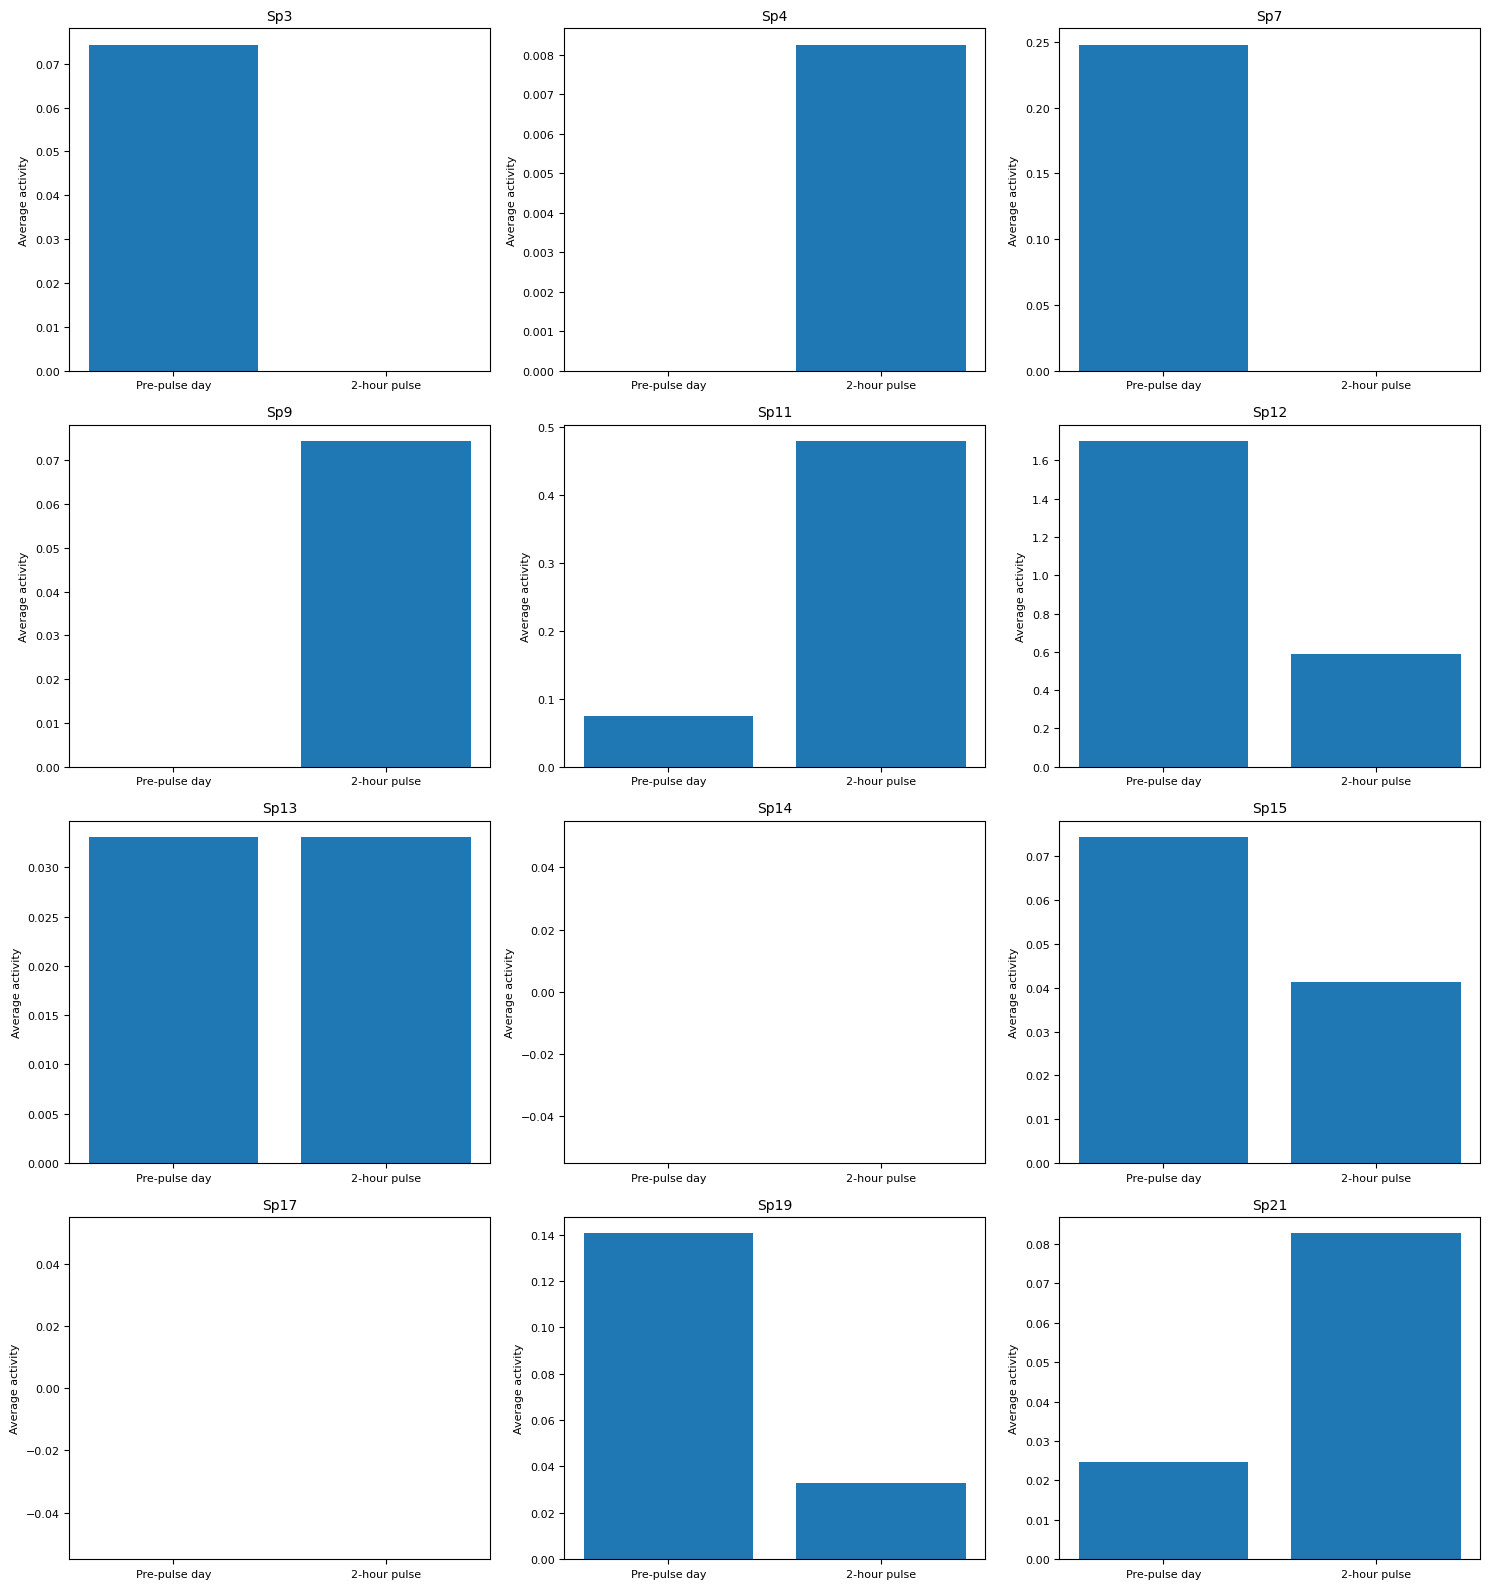

   Spider  Mean Pre-pulse Activity  Mean Pulse Activity
0     Sp3                 0.074380             0.000000
1     Sp4                 0.000000             0.008264
2     Sp7                 0.247934             0.000000
3     Sp9                 0.000000             0.074380
4    Sp11                 0.074380             0.479339
5    Sp12                 1.702479             0.586777
6    Sp13                 0.033058             0.033058
7    Sp14                 0.000000             0.000000
8    Sp15                 0.074380             0.041322
9    Sp17                 0.000000             0.000000
10   Sp19                 0.140496             0.033058
11   Sp21                 0.024793             0.082645


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def filter_and_compare_activity(df, day_pulse, day_pre_pulse, start_hour, end_hour):
    # Get the unique dates for the specified days
    pre_pulse_date = df.loc[df['Day'] == day_pre_pulse, 'Time'].dt.date.unique()[0]
    pulse_date = df.loc[df['Day'] == day_pulse, 'Time'].dt.date.unique()[0]
    
    # Construct start and end times with the correct dates
    start_time_pre_pulse = pd.to_datetime(f"{pre_pulse_date} {start_hour}")
    end_time_pre_pulse = pd.to_datetime(f"{pre_pulse_date} {end_hour}")
    start_time_pulse = pd.to_datetime(f"{pulse_date} {start_hour}")
    end_time_pulse = pd.to_datetime(f"{pulse_date} {end_hour}")
    
    # Filter the days
    day_pre = df.loc[df['Day'] == day_pre_pulse]
    day_pulse = df.loc[df['Day'] == day_pulse]
    
    # Filter the time range for the specified days
    day_pre_filtered = day_pre[(day_pre['Time'] >= start_time_pre_pulse) & (day_pre['Time'] <= end_time_pre_pulse)]
    day_pulse_filtered = day_pulse[(day_pulse['Time'] >= start_time_pulse) & (day_pulse['Time'] <= end_time_pulse)]
    
    # Initialize a list to store mean activity data for each spider
    spider_means = []
    
    # Loop through each spider column
    spider_columns = [col for col in df.columns if col.startswith('Sp')]
    
    # Calculate the number of rows and columns for the grid
    num_spiders = len(spider_columns)
    num_cols = 3  # You can adjust this value based on how many columns you want in the grid
    num_rows = (num_spiders + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
    axes = axes.flatten()  # Flatten the axes array to easily index it
    
    for idx, spider_col in enumerate(spider_columns):
        # Filter for the specific spider column
        spider_day_pre = day_pre_filtered[spider_col]
        spider_day_pulse = day_pulse_filtered[spider_col]
        
        # Calculate the mean activity
        mean_day_pre = spider_day_pre.mean()
        mean_day_pulse = spider_day_pulse.mean()
        
        # Append the results to the spider_means list
        spider_means.append((spider_col, mean_day_pre, mean_day_pulse))
        
        # Plot the results for each spider in the grid
        ax = axes[idx]
        days = ['Pre-pulse day', '2-hour pulse']
        means = [mean_day_pre, mean_day_pulse]
        
        ax.bar(days, means)
        ax.set_title(f'{spider_col}', fontsize=10)
        ax.set_ylabel('Average activity', fontsize=8)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(days, fontsize=8)
        ax.tick_params(axis='y', labelsize=8)
    
    # Remove any empty subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()
    
    # Create a DataFrame to store the means for all spiders
    means_df = pd.DataFrame(spider_means, columns=['Spider', 'Mean Pre-pulse Activity', 'Mean Pulse Activity'])
    
    return means_df

# Example usage
# Define the parameters
day_pulse = 5  # The day when the pulse occurred
day_pre_pulse = 4  # The day before the pulse
start_hour = '16:00:00'  # Replace with the desired start hour
end_hour = '18:00:00'  # Replace with the desired end hour

# Ensure 'Time' is in datetime format
merged_dfx1['Time'] = pd.to_datetime(merged_dfx1['Time'])

# Call the function using the existing df
means_df = filter_and_compare_activity(merged_dfx1, day_pulse, day_pre_pulse, start_hour, end_hour)
print(means_df)


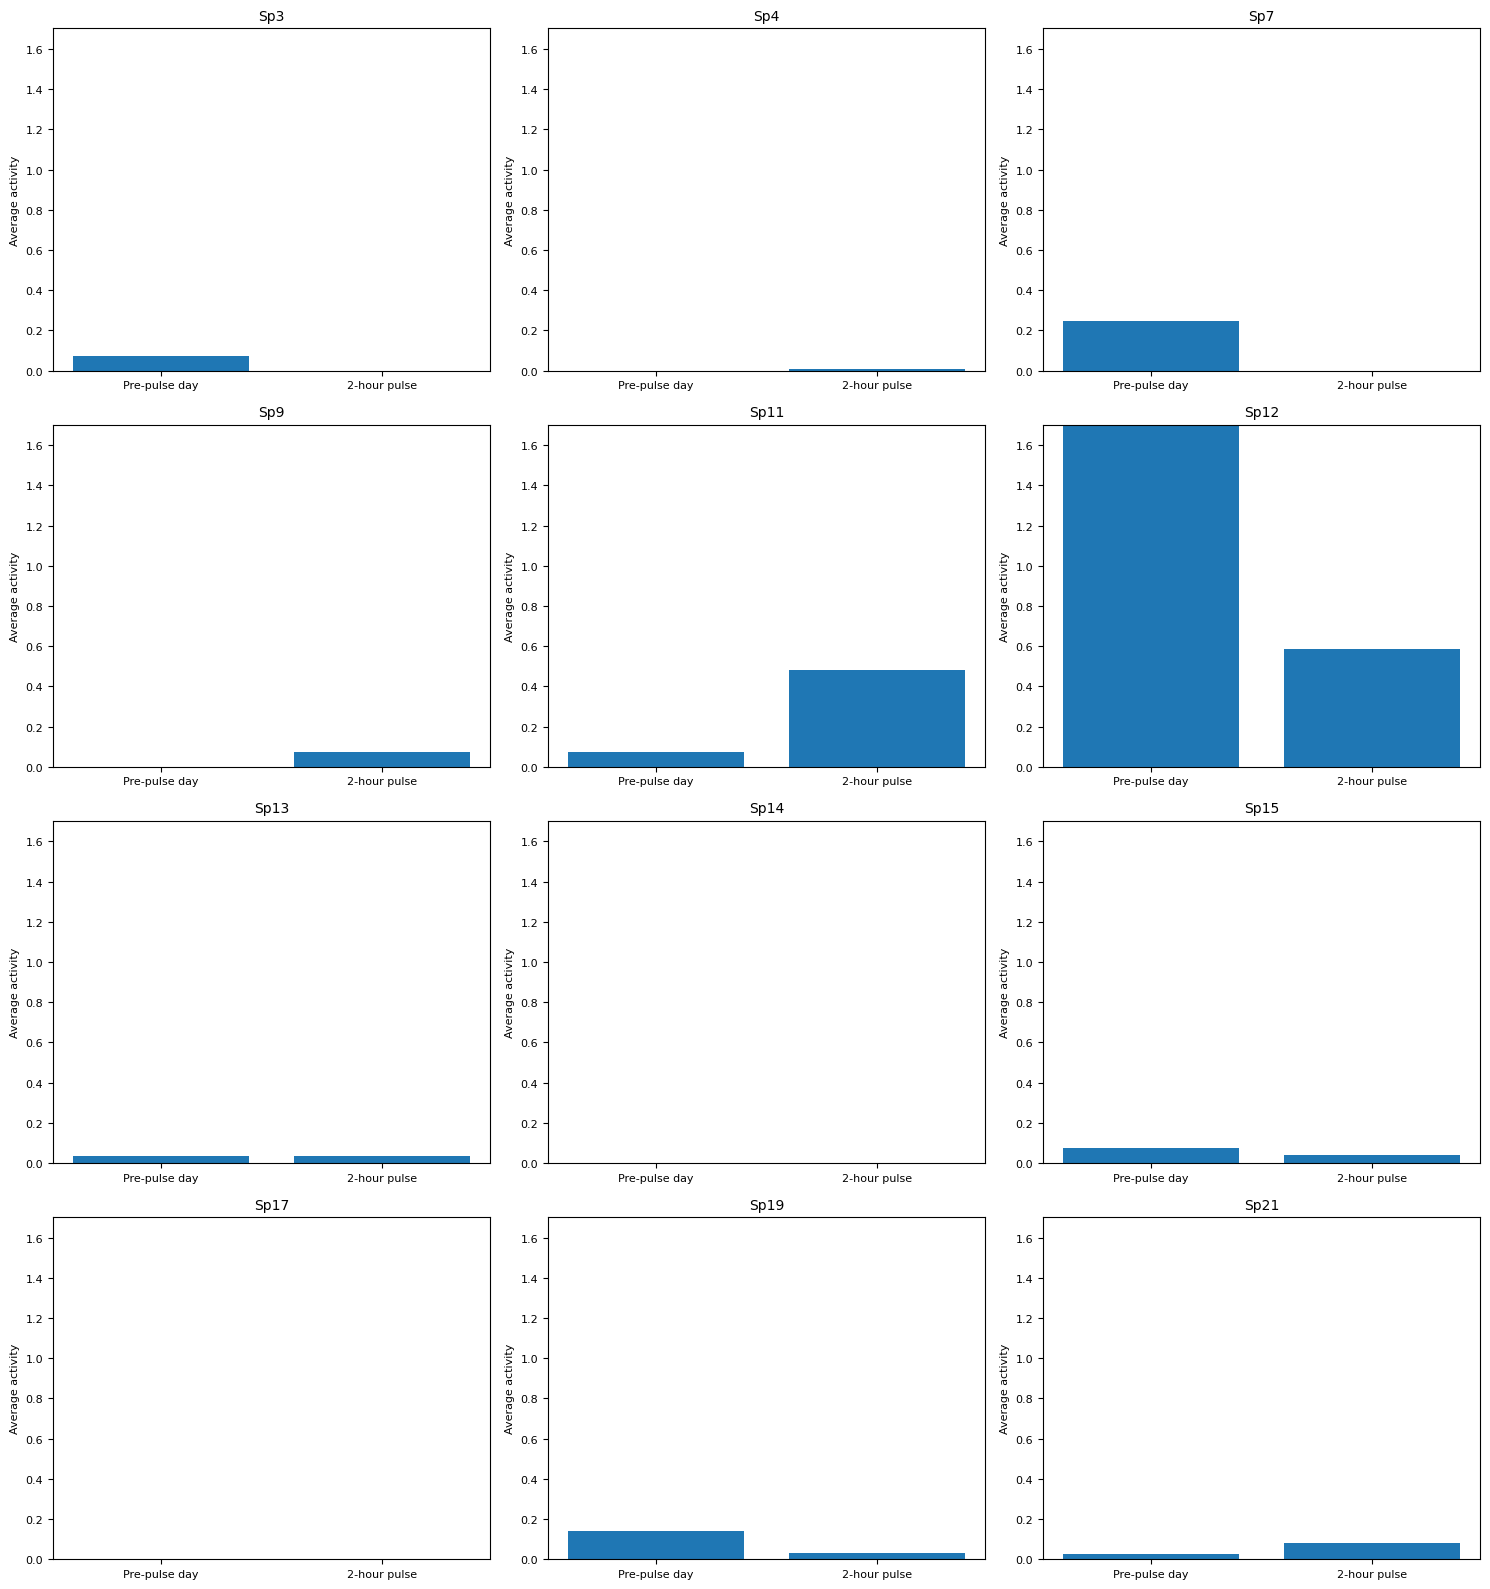

   Spider  Mean Pre-pulse Activity  Mean Pulse Activity
0     Sp3                 0.074380             0.000000
1     Sp4                 0.000000             0.008264
2     Sp7                 0.247934             0.000000
3     Sp9                 0.000000             0.074380
4    Sp11                 0.074380             0.479339
5    Sp12                 1.702479             0.586777
6    Sp13                 0.033058             0.033058
7    Sp14                 0.000000             0.000000
8    Sp15                 0.074380             0.041322
9    Sp17                 0.000000             0.000000
10   Sp19                 0.140496             0.033058
11   Sp21                 0.024793             0.082645


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def filter_and_compare_activity(df, day_pulse, day_pre_pulse, start_hour, end_hour):
    # Get the unique dates for the specified days
    pre_pulse_date = df.loc[df['Day'] == day_pre_pulse, 'Time'].dt.date.unique()[0]
    pulse_date = df.loc[df['Day'] == day_pulse, 'Time'].dt.date.unique()[0]
    
    # Construct start and end times with the correct dates
    start_time_pre_pulse = pd.to_datetime(f"{pre_pulse_date} {start_hour}")
    end_time_pre_pulse = pd.to_datetime(f"{pre_pulse_date} {end_hour}")
    start_time_pulse = pd.to_datetime(f"{pulse_date} {start_hour}")
    end_time_pulse = pd.to_datetime(f"{pulse_date} {end_hour}")
    
    # Filter the days
    day_pre = df.loc[df['Day'] == day_pre_pulse]
    day_pulse = df.loc[df['Day'] == day_pulse]
    
    # Filter the time range for the specified days
    day_pre_filtered = day_pre[(day_pre['Time'] >= start_time_pre_pulse) & (day_pre['Time'] <= end_time_pre_pulse)]
    day_pulse_filtered = day_pulse[(day_pulse['Time'] >= start_time_pulse) & (day_pulse['Time'] <= end_time_pulse)]
    
    # Initialize a list to store mean activity data for each spider
    spider_means = []
    
    # Loop through each spider column
    spider_columns = [col for col in df.columns if col.startswith('Sp')]
    
    # Calculate the number of rows and columns for the grid
    num_spiders = len(spider_columns)
    num_cols = 3  # You can adjust this value based on how many columns you want in the grid
    num_rows = (num_spiders + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
    axes = axes.flatten()  # Flatten the axes array to easily index it
    
    for idx, spider_col in enumerate(spider_columns):
        # Filter for the specific spider column
        spider_day_pre = day_pre_filtered[spider_col]
        spider_day_pulse = day_pulse_filtered[spider_col]
        
        # Calculate the mean activity
        mean_day_pre = spider_day_pre.mean()
        mean_day_pulse = spider_day_pulse.mean()
        
        # Append the results to the spider_means list
        spider_means.append((spider_col, mean_day_pre, mean_day_pulse))
        
        # Plot the results for each spider in the grid
        ax = axes[idx]
        days = ['Pre-pulse day', '2-hour pulse']
        means = [mean_day_pre, mean_day_pulse]
        
        ax.bar(days, means)
        ax.set_title(f'{spider_col}', fontsize=10)
        ax.set_ylabel('Average activity', fontsize=8)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(days, fontsize=8)
        ax.tick_params(axis='y', labelsize=8)
    
    # Remove any empty subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Find the maximum mean activity across all spiders
    max_mean_activity = max([mean for _, mean_pre, mean_pulse in spider_means for mean in (mean_pre, mean_pulse)])
    
    # Set the same y-axis range for all subplots
    for ax in axes:
        ax.set_ylim(0, max_mean_activity)
    
    plt.tight_layout()
    plt.show()
    
    # Create a DataFrame to store the means for all spiders
    means_df = pd.DataFrame(spider_means, columns=['Spider', 'Mean Pre-pulse Activity', 'Mean Pulse Activity'])
    
    return means_df

# Example usage
# Define the parameters
day_pulse = 5  # The day when the pulse occurred
day_pre_pulse = 4  # The day before the pulse
start_hour = '16:00:00'  # Replace with the desired start hour
end_hour = '18:00:00'  # Replace with the desired end hour

# Ensure 'Time' is in datetime format
merged_dfx1['Time'] = pd.to_datetime(merged_dfx1['Time'])

# Call the function using the existing df
means_df = filter_and_compare_activity(merged_dfx1, day_pulse, day_pre_pulse, start_hour, end_hour)
print(means_df)


In [10]:
# filtering for a single day 
day1 = df[df['Day'] == 1]
count_mov = day1.filter(like="Sp")  
sum_count = count_mov.sum(axis=0) 
threshold = 0
filter_sum = sum_count > threshold 
columns_to_keep = filter_sum[filter_sum].index  
additional_columns = df.columns[:3]
all_columns_to_keep = list(additional_columns) + list(columns_to_keep)
filtered_df = day1[all_columns_to_keep]
display(filtered_df)

,Day,Time,Light,Sp3,Sp4,Sp5,Sp7,Sp9,Sp10,Sp11,...,Sp14,Sp15,Sp16,Sp17,Sp18,Sp19,Sp21,Sp22,Sp23,Sp25
Index,,,,,,,,,,,,,,,,,,,,,
14,1,2024-04-17 15:56:00,1,0,16,0,2,0,0,0,...,0,0,0,0,0,2,0,0,0,0
15,1,2024-04-17 15:57:00,1,0,8,0,3,0,0,0,...,0,0,0,0,0,1,0,0,0,0
16,1,2024-04-17 15:58:00,1,0,8,0,4,0,1,0,...,0,0,0,0,0,6,0,0,0,0
17,1,2024-04-17 15:59:00,1,0,15,0,2,0,3,0,...,0,0,0,0,0,1,0,0,0,0
18,1,2024-04-17 16:00:00,1,0,9,0,2,0,0,0,...,0,0,0,0,0,4,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,1,2024-04-17 23:55:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
494,1,2024-04-17 23:56:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
495,1,2024-04-17 23:57:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
#filtering for all days 
import pandas as pd

threshold = 0
additional_columns = df.columns[:3]
filtered_dfs = []

for day in range(1, 9):  
    day_df = df[df['Day'] == day] 
    count_mov = day_df.filter(like="Sp")  
    x = count_mov.sum(axis=0)  
    z = x > threshold  
    columns_to_keep = z[z].index 
    
    all_columns_to_keep = list(additional_columns) + list(columns_to_keep)
    filtered_df = day_df[all_columns_to_keep]
    filtered_dfs.append(filtered_df)

merged_df = pd.concat(filtered_dfs)
merged_df1 = merged_df.dropna(axis=1)
display(merged_df1)

,Day,Time,Light,Sp3,Sp4,Sp7,Sp9,Sp10,Sp11,Sp12,Sp13,Sp14,Sp15,Sp17,Sp19,Sp21,Sp25
Index,,,,,,,,,,,,,,,,,
14,1,2024-04-17 15:56:00,1,0,16,2,0,0,0,26,0,0,0,0,2,0,0
15,1,2024-04-17 15:57:00,1,0,8,3,0,0,0,17,0,0,0,0,1,0,0
16,1,2024-04-17 15:58:00,1,0,8,4,0,1,0,19,0,0,0,0,6,0,0
17,1,2024-04-17 15:59:00,1,0,15,2,0,3,0,11,0,0,0,0,1,0,0
18,1,2024-04-17 16:00:00,1,0,9,2,0,0,0,14,6,0,0,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10036,8,2024-04-24 14:58:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10037,8,2024-04-24 14:59:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10038,8,2024-04-24 15:00:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
#function to filter 
import pandas as pd

def filter_and_merge(df, threshold=0):
    additional_columns = df.columns[:3]
    filtered_dfs = []

    for day in range(1, 9):  
        day_df = df[df['Day'] == day] 
        count_mov = day_df.filter(like="Sp")  
        x = count_mov.sum(axis=0)  
        z = x > threshold  
        columns_to_keep = z[z].index 
        
        all_columns_to_keep = list(additional_columns) + list(columns_to_keep)
        filtered_df = day_df[all_columns_to_keep]
        filtered_dfs.append(filtered_df)

    merged_df = pd.concat(filtered_dfs)
    merged_df1 = merged_df.dropna(axis=1)
    
    return merged_df1
    
merged_df = filter_and_merge(df)
display(merged_df)

,Day,Time,Light,Sp3,Sp4,Sp7,Sp9,Sp10,Sp11,Sp12,Sp13,Sp14,Sp15,Sp17,Sp19,Sp21,Sp25
Index,,,,,,,,,,,,,,,,,
14,1,2024-04-17 15:56:00,1,0,16,2,0,0,0,26,0,0,0,0,2,0,0
15,1,2024-04-17 15:57:00,1,0,8,3,0,0,0,17,0,0,0,0,1,0,0
16,1,2024-04-17 15:58:00,1,0,8,4,0,1,0,19,0,0,0,0,6,0,0
17,1,2024-04-17 15:59:00,1,0,15,2,0,3,0,11,0,0,0,0,1,0,0
18,1,2024-04-17 16:00:00,1,0,9,2,0,0,0,14,6,0,0,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10036,8,2024-04-24 14:58:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10037,8,2024-04-24 14:59:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10038,8,2024-04-24 15:00:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
#have the dataframes all at once 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

def process_file(file):
    col_names = ["Index", "DateD", "DateM", "DateY", "Time", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused", "Light"]
    
    for i in range(1, 33):
        col_names.append(f"Sp{i}")
    
    df = pd.read_csv(file, names=col_names, sep='\s+', header=None)
    df = df.set_index('Index')
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')
    df = df[df["MonStatus"] == 1]

    month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6}
    df['DateM'] = df['DateM'].str[:3].map(month_map)
    df['DateY'] = df['DateY'].apply(lambda x: int(str(20) + str(x)))
    df['Date'] = pd.to_datetime(dict(year=df['DateY'], month=df['DateM'], day=df['DateD']), errors='coerce')

    df['Time'] = pd.to_datetime(dict(year=df['Date'].dt.year,
                                     month=df['Date'].dt.month,
                                     day=df['Date'].dt.day,
                                     hour=df['Time'].dt.hour,
                                     minute=df['Time'].dt.minute,
                                     second=df['Time'].dt.second))

    df = df.drop(["DateD", "DateM", "DateY", "Date", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused"], axis=1)

    day_map = {day: idx+1 for idx, day in enumerate(df['Time'].dt.day.unique())}

    df.insert(0, 'Day', df['Time'].dt.day.map(day_map))
    
    return df

def process_files(files):
    dataframes = {}
    for idx, file in enumerate(files, start=1):
        df = process_file(file)
        dataframes[f'df{idx}'] = df
    return dataframes

files = ['Steatoda A masking 02 pm.txt', 'Steatoda A masking 10 am.txt', 'Steatoda A masking 4 am.txt', 'Steatoda A masking midnight.txt', 'Steatoda B masking 04 pm.txt', 'Steatoda B masking 10 pm.txt', 'Steatoda B masking 12 pm.txt', 'Steatoda B maskng 2am.txt']

dataframes = process_files(files)
for name, df in dataframes.items():
    print(f"{name}:")
    display(df)


df1:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
1,1,2024-03-20 11:04:00,1,0,0,2,2,15,0,8,...,0,0,2,0,0,0,0,0,0,0
2,1,2024-03-20 11:05:00,1,0,0,5,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,2024-03-20 11:06:00,1,0,0,3,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,2024-03-20 11:07:00,1,0,0,0,1,3,0,0,...,1,0,1,0,0,0,0,0,0,0
5,1,2024-03-20 11:08:00,1,0,0,0,1,4,0,0,...,0,0,2,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10040,8,2024-03-27 10:23:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10041,8,2024-03-27 10:24:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10042,8,2024-03-27 10:25:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df2:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
1,1,2024-03-07 10:34:00,1,0,0,1,0,0,0,21,...,0,0,0,0,0,0,0,0,0,0
2,1,2024-03-07 10:35:00,1,0,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,0
3,1,2024-03-07 10:36:00,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,2024-03-07 10:37:00,1,0,0,0,0,0,7,7,...,0,5,0,0,0,0,0,0,0,0
5,1,2024-03-07 10:38:00,1,0,0,0,0,2,12,6,...,0,2,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9081,7,2024-03-13 18:54:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9082,7,2024-03-13 18:55:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9083,7,2024-03-13 18:56:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df3:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
19677,1,2024-05-01 07:39:00,1,0,0,3,2,4,0,1,...,0,0,0,0,0,0,0,0,0,0
19678,1,2024-05-01 07:40:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19679,1,2024-05-01 07:41:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19680,1,2024-05-01 07:42:00,1,0,0,3,0,7,0,0,...,0,0,0,0,0,0,0,0,0,0
19681,1,2024-05-01 07:43:00,1,0,0,2,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29808,8,2024-05-08 08:30:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29809,8,2024-05-08 08:31:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29810,8,2024-05-08 08:32:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df4:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
14,1,2024-04-17 15:56:00,1,0,0,0,16,0,0,2,...,0,0,0,0,0,0,0,0,0,0
15,1,2024-04-17 15:57:00,1,0,0,0,8,0,0,3,...,0,0,0,0,0,0,0,0,0,0
16,1,2024-04-17 15:58:00,1,0,0,0,8,0,0,4,...,0,0,0,0,0,0,0,0,0,0
17,1,2024-04-17 15:59:00,1,0,0,0,15,0,0,2,...,0,0,0,0,0,0,0,0,0,0
18,1,2024-04-17 16:00:00,1,0,0,0,9,0,0,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10036,8,2024-04-24 14:58:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10037,8,2024-04-24 14:59:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10038,8,2024-04-24 15:00:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df5:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
1,1,2024-03-27 09:45:00,1,0,0,1,3,5,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2024-03-27 09:46:00,1,0,0,0,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,2024-03-27 09:47:00,1,0,0,1,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,2024-03-27 09:48:00,1,0,0,1,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,2024-03-27 09:49:00,1,0,0,1,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10090,8,2024-04-03 09:54:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10091,8,2024-04-03 09:55:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10092,8,2024-04-03 09:56:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df6:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
1,1,2024-04-10 09:38:00,1,9,1,2,1,3,1,1,...,1,0,0,0,0,0,0,0,0,0
2,1,2024-04-10 09:39:00,1,0,0,0,0,4,0,2,...,0,0,0,0,0,0,0,0,0,0
3,1,2024-04-10 09:40:00,1,0,0,0,0,8,0,0,...,2,0,0,0,0,0,0,0,0,0
4,1,2024-04-10 09:41:00,1,0,0,0,0,2,0,7,...,7,0,0,0,0,0,0,0,0,0
5,1,2024-04-10 09:42:00,1,2,0,0,0,6,0,2,...,3,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7561,6,2024-04-15 15:38:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7562,6,2024-04-15 15:39:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7563,6,2024-04-15 15:40:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df7:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
2,1,2024-03-13 19:09:00,1,0,1,0,0,3,0,0,...,3,0,0,0,0,0,0,0,0,0
3,1,2024-03-13 19:10:00,1,0,1,0,3,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,2024-03-13 19:11:00,1,0,1,0,2,3,0,1,...,0,0,0,0,0,0,0,0,0,0
5,1,2024-03-13 19:12:00,1,0,1,0,4,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,2024-03-13 19:13:00,1,3,0,0,1,1,0,4,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9585,8,2024-03-20 10:52:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9586,8,2024-03-20 10:53:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9587,8,2024-03-20 10:54:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df8:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
10113,1,2024-04-24 16:15:00,1,0,4,0,0,8,0,3,...,0,0,0,0,0,0,0,0,0,0
10114,1,2024-04-24 16:16:00,1,0,2,0,0,8,2,5,...,0,0,0,0,0,0,0,0,0,0
10115,1,2024-04-24 16:17:00,1,3,0,0,0,5,2,0,...,0,0,0,0,0,0,0,0,0,0
10116,1,2024-04-24 16:18:00,1,3,0,0,0,4,5,0,...,0,0,0,0,0,0,0,0,0,0
10117,1,2024-04-24 16:19:00,1,1,0,0,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19666,8,2024-05-01 07:28:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19667,8,2024-05-01 07:29:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19668,8,2024-05-01 07:30:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
filter_and_merge(df, threshold=0)

,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,Sp11,Sp12,Sp13,Sp14,Sp17,Sp18,Sp19,Sp21,Sp22,Sp23
Index,,,,,,,,,,,,,,,,,,,,
10113,1,2024-04-24 16:15:00,1,0,4,0,0,8,0,3,0,3,0,6,3,1,0,0,0,0
10114,1,2024-04-24 16:16:00,1,0,2,0,0,8,2,5,0,4,0,2,5,6,0,3,0,0
10115,1,2024-04-24 16:17:00,1,3,0,0,0,5,2,0,5,9,0,3,0,1,0,3,0,0
10116,1,2024-04-24 16:18:00,1,3,0,0,0,4,5,0,9,6,0,9,2,4,0,7,0,0
10117,1,2024-04-24 16:19:00,1,1,0,0,1,5,0,0,5,2,0,6,2,4,3,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19666,8,2024-05-01 07:28:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19667,8,2024-05-01 07:29:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19668,8,2024-05-01 07:30:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
#have the dataframes all at once 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

def process_file(file):
    col_names = ["Index", "DateD", "DateM", "DateY", "Time", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused", "Light"]
    
    for i in range(1, 33):
        col_names.append(f"Sp{i}")
    
    df = pd.read_csv(file, names=col_names, sep='\s+', header=None)
    df = df.set_index('Index')
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')
    df = df[df["MonStatus"] == 1]

    month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6}
    df['DateM'] = df['DateM'].str[:3].map(month_map)
    df['DateY'] = df['DateY'].apply(lambda x: int(str(20) + str(x)))
    df['Date'] = pd.to_datetime(dict(year=df['DateY'], month=df['DateM'], day=df['DateD']), errors='coerce')

    df['Time'] = pd.to_datetime(dict(year=df['Date'].dt.year,
                                     month=df['Date'].dt.month,
                                     day=df['Date'].dt.day,
                                     hour=df['Time'].dt.hour,
                                     minute=df['Time'].dt.minute,
                                     second=df['Time'].dt.second))

    df = df.drop(["DateD", "DateM", "DateY", "Date", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused"], axis=1)

    day_map = {day: idx+1 for idx, day in enumerate(df['Time'].dt.day.unique())}

    df.insert(0, 'Day', df['Time'].dt.day.map(day_map))
    
    return df

def process_files(files):
    dataframes = {}
    for idx, file in enumerate(files, start=1):
        df = process_file(file)
        dataframes[f'df{idx}'] = df
    return dataframes

files = ['Steatoda A masking 02 pm.txt', 'Steatoda A masking 10 am.txt', 'Steatoda A masking 4 am.txt', 'Steatoda A masking midnight.txt', 'Steatoda B masking 04 pm.txt', 'Steatoda B masking 10 pm.txt', 'Steatoda B masking 12 pm.txt', 'Steatoda B maskng 2am.txt']

dataframes = process_files(files)
for name, df in dataframes.items():
    print(f"{name}:")
    display(df)


df1:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
1,1,2024-03-20 11:04:00,1,0,0,2,2,15,0,8,...,0,0,2,0,0,0,0,0,0,0
2,1,2024-03-20 11:05:00,1,0,0,5,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,2024-03-20 11:06:00,1,0,0,3,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,2024-03-20 11:07:00,1,0,0,0,1,3,0,0,...,1,0,1,0,0,0,0,0,0,0
5,1,2024-03-20 11:08:00,1,0,0,0,1,4,0,0,...,0,0,2,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10040,8,2024-03-27 10:23:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10041,8,2024-03-27 10:24:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10042,8,2024-03-27 10:25:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df2:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
1,1,2024-03-07 10:34:00,1,0,0,1,0,0,0,21,...,0,0,0,0,0,0,0,0,0,0
2,1,2024-03-07 10:35:00,1,0,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,0
3,1,2024-03-07 10:36:00,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,2024-03-07 10:37:00,1,0,0,0,0,0,7,7,...,0,5,0,0,0,0,0,0,0,0
5,1,2024-03-07 10:38:00,1,0,0,0,0,2,12,6,...,0,2,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9081,7,2024-03-13 18:54:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9082,7,2024-03-13 18:55:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9083,7,2024-03-13 18:56:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df3:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
19677,1,2024-05-01 07:39:00,1,0,0,3,2,4,0,1,...,0,0,0,0,0,0,0,0,0,0
19678,1,2024-05-01 07:40:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19679,1,2024-05-01 07:41:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19680,1,2024-05-01 07:42:00,1,0,0,3,0,7,0,0,...,0,0,0,0,0,0,0,0,0,0
19681,1,2024-05-01 07:43:00,1,0,0,2,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29808,8,2024-05-08 08:30:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29809,8,2024-05-08 08:31:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29810,8,2024-05-08 08:32:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df4:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
14,1,2024-04-17 15:56:00,1,0,0,0,16,0,0,2,...,0,0,0,0,0,0,0,0,0,0
15,1,2024-04-17 15:57:00,1,0,0,0,8,0,0,3,...,0,0,0,0,0,0,0,0,0,0
16,1,2024-04-17 15:58:00,1,0,0,0,8,0,0,4,...,0,0,0,0,0,0,0,0,0,0
17,1,2024-04-17 15:59:00,1,0,0,0,15,0,0,2,...,0,0,0,0,0,0,0,0,0,0
18,1,2024-04-17 16:00:00,1,0,0,0,9,0,0,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10036,8,2024-04-24 14:58:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10037,8,2024-04-24 14:59:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10038,8,2024-04-24 15:00:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df5:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
1,1,2024-03-27 09:45:00,1,0,0,1,3,5,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2024-03-27 09:46:00,1,0,0,0,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,2024-03-27 09:47:00,1,0,0,1,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,2024-03-27 09:48:00,1,0,0,1,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,2024-03-27 09:49:00,1,0,0,1,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10090,8,2024-04-03 09:54:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10091,8,2024-04-03 09:55:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10092,8,2024-04-03 09:56:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df6:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
1,1,2024-04-10 09:38:00,1,9,1,2,1,3,1,1,...,1,0,0,0,0,0,0,0,0,0
2,1,2024-04-10 09:39:00,1,0,0,0,0,4,0,2,...,0,0,0,0,0,0,0,0,0,0
3,1,2024-04-10 09:40:00,1,0,0,0,0,8,0,0,...,2,0,0,0,0,0,0,0,0,0
4,1,2024-04-10 09:41:00,1,0,0,0,0,2,0,7,...,7,0,0,0,0,0,0,0,0,0
5,1,2024-04-10 09:42:00,1,2,0,0,0,6,0,2,...,3,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7561,6,2024-04-15 15:38:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7562,6,2024-04-15 15:39:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7563,6,2024-04-15 15:40:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df7:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
2,1,2024-03-13 19:09:00,1,0,1,0,0,3,0,0,...,3,0,0,0,0,0,0,0,0,0
3,1,2024-03-13 19:10:00,1,0,1,0,3,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,2024-03-13 19:11:00,1,0,1,0,2,3,0,1,...,0,0,0,0,0,0,0,0,0,0
5,1,2024-03-13 19:12:00,1,0,1,0,4,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,2024-03-13 19:13:00,1,3,0,0,1,1,0,4,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9585,8,2024-03-20 10:52:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9586,8,2024-03-20 10:53:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9587,8,2024-03-20 10:54:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df8:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
10113,1,2024-04-24 16:15:00,1,0,4,0,0,8,0,3,...,0,0,0,0,0,0,0,0,0,0
10114,1,2024-04-24 16:16:00,1,0,2,0,0,8,2,5,...,0,0,0,0,0,0,0,0,0,0
10115,1,2024-04-24 16:17:00,1,3,0,0,0,5,2,0,...,0,0,0,0,0,0,0,0,0,0
10116,1,2024-04-24 16:18:00,1,3,0,0,0,4,5,0,...,0,0,0,0,0,0,0,0,0,0
10117,1,2024-04-24 16:19:00,1,1,0,0,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19666,8,2024-05-01 07:28:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19667,8,2024-05-01 07:29:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19668,8,2024-05-01 07:30:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
#have the dataframes all at once 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

def process_file(file):
    col_names = ["Index", "DateD", "DateM", "DateY", "Time", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused", "Light"]
    
    for i in range(1, 33):
        col_names.append(f"Sp{i}")
    
    df = pd.read_csv(file, names=col_names, sep='\s+', header=None)
    df = df.set_index('Index')
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')
    df = df[df["MonStatus"] == 1]

    month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6}
    df['DateM'] = df['DateM'].str[:3].map(month_map)
    df['DateY'] = df['DateY'].apply(lambda x: int(str(20) + str(x)))
    df['Date'] = pd.to_datetime(dict(year=df['DateY'], month=df['DateM'], day=df['DateD']), errors='coerce')

    df['Time'] = pd.to_datetime(dict(year=df['Date'].dt.year,
                                     month=df['Date'].dt.month,
                                     day=df['Date'].dt.day,
                                     hour=df['Time'].dt.hour,
                                     minute=df['Time'].dt.minute,
                                     second=df['Time'].dt.second))

    df = df.drop(["DateD", "DateM", "DateY", "Date", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused"], axis=1)

    day_map = {day: idx+1 for idx, day in enumerate(df['Time'].dt.day.unique())}

    df.insert(0, 'Day', df['Time'].dt.day.map(day_map))
    
    return df

def process_files(files):
    dataframes = {}
    for idx, file in enumerate(files, start=1):
        df = process_file(file)
        dataframes[f'df{idx}'] = df
    return dataframes

files = ['Steatoda A masking 02 pm.txt', 'Steatoda A masking 10 am.txt', 'Steatoda A masking 4 am.txt', 'Steatoda A masking midnight.txt', 'Steatoda B masking 04 pm.txt', 'Steatoda B masking 10 pm.txt', 'Steatoda B masking 12 pm.txt', 'Steatoda B maskng 2am.txt']

dataframes = process_files(files)
for name, df in dataframes.items():
    print(f"{name}:")
    display(df)


df1:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
1,1,2024-03-20 11:04:00,1,0,0,2,2,15,0,8,...,0,0,2,0,0,0,0,0,0,0
2,1,2024-03-20 11:05:00,1,0,0,5,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,2024-03-20 11:06:00,1,0,0,3,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,2024-03-20 11:07:00,1,0,0,0,1,3,0,0,...,1,0,1,0,0,0,0,0,0,0
5,1,2024-03-20 11:08:00,1,0,0,0,1,4,0,0,...,0,0,2,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10040,8,2024-03-27 10:23:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10041,8,2024-03-27 10:24:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10042,8,2024-03-27 10:25:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df2:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
1,1,2024-03-07 10:34:00,1,0,0,1,0,0,0,21,...,0,0,0,0,0,0,0,0,0,0
2,1,2024-03-07 10:35:00,1,0,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,0
3,1,2024-03-07 10:36:00,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,2024-03-07 10:37:00,1,0,0,0,0,0,7,7,...,0,5,0,0,0,0,0,0,0,0
5,1,2024-03-07 10:38:00,1,0,0,0,0,2,12,6,...,0,2,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9081,7,2024-03-13 18:54:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9082,7,2024-03-13 18:55:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9083,7,2024-03-13 18:56:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df3:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
19677,1,2024-05-01 07:39:00,1,0,0,3,2,4,0,1,...,0,0,0,0,0,0,0,0,0,0
19678,1,2024-05-01 07:40:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19679,1,2024-05-01 07:41:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19680,1,2024-05-01 07:42:00,1,0,0,3,0,7,0,0,...,0,0,0,0,0,0,0,0,0,0
19681,1,2024-05-01 07:43:00,1,0,0,2,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29808,8,2024-05-08 08:30:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29809,8,2024-05-08 08:31:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29810,8,2024-05-08 08:32:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df4:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
14,1,2024-04-17 15:56:00,1,0,0,0,16,0,0,2,...,0,0,0,0,0,0,0,0,0,0
15,1,2024-04-17 15:57:00,1,0,0,0,8,0,0,3,...,0,0,0,0,0,0,0,0,0,0
16,1,2024-04-17 15:58:00,1,0,0,0,8,0,0,4,...,0,0,0,0,0,0,0,0,0,0
17,1,2024-04-17 15:59:00,1,0,0,0,15,0,0,2,...,0,0,0,0,0,0,0,0,0,0
18,1,2024-04-17 16:00:00,1,0,0,0,9,0,0,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10036,8,2024-04-24 14:58:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10037,8,2024-04-24 14:59:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10038,8,2024-04-24 15:00:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df5:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
1,1,2024-03-27 09:45:00,1,0,0,1,3,5,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2024-03-27 09:46:00,1,0,0,0,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,2024-03-27 09:47:00,1,0,0,1,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,2024-03-27 09:48:00,1,0,0,1,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,2024-03-27 09:49:00,1,0,0,1,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10090,8,2024-04-03 09:54:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10091,8,2024-04-03 09:55:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10092,8,2024-04-03 09:56:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df6:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
1,1,2024-04-10 09:38:00,1,9,1,2,1,3,1,1,...,1,0,0,0,0,0,0,0,0,0
2,1,2024-04-10 09:39:00,1,0,0,0,0,4,0,2,...,0,0,0,0,0,0,0,0,0,0
3,1,2024-04-10 09:40:00,1,0,0,0,0,8,0,0,...,2,0,0,0,0,0,0,0,0,0
4,1,2024-04-10 09:41:00,1,0,0,0,0,2,0,7,...,7,0,0,0,0,0,0,0,0,0
5,1,2024-04-10 09:42:00,1,2,0,0,0,6,0,2,...,3,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7561,6,2024-04-15 15:38:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7562,6,2024-04-15 15:39:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7563,6,2024-04-15 15:40:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df7:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
2,1,2024-03-13 19:09:00,1,0,1,0,0,3,0,0,...,3,0,0,0,0,0,0,0,0,0
3,1,2024-03-13 19:10:00,1,0,1,0,3,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,2024-03-13 19:11:00,1,0,1,0,2,3,0,1,...,0,0,0,0,0,0,0,0,0,0
5,1,2024-03-13 19:12:00,1,0,1,0,4,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,2024-03-13 19:13:00,1,3,0,0,1,1,0,4,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9585,8,2024-03-20 10:52:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9586,8,2024-03-20 10:53:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9587,8,2024-03-20 10:54:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df8:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
10113,1,2024-04-24 16:15:00,1,0,4,0,0,8,0,3,...,0,0,0,0,0,0,0,0,0,0
10114,1,2024-04-24 16:16:00,1,0,2,0,0,8,2,5,...,0,0,0,0,0,0,0,0,0,0
10115,1,2024-04-24 16:17:00,1,3,0,0,0,5,2,0,...,0,0,0,0,0,0,0,0,0,0
10116,1,2024-04-24 16:18:00,1,3,0,0,0,4,5,0,...,0,0,0,0,0,0,0,0,0,0
10117,1,2024-04-24 16:19:00,1,1,0,0,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19666,8,2024-05-01 07:28:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19667,8,2024-05-01 07:29:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19668,8,2024-05-01 07:30:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

def process_file(file):
    col_names = ["Index", "DateD", "DateM", "DateY", "Time", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused", "Light"]
    
    for i in range(1, 33):
        col_names.append(f"Sp{i}")
    
    df = pd.read_csv(file, names=col_names, sep='\s+', header=None)
    df = df.set_index('Index')
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')
    df = df[df["MonStatus"] == 1]

    month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6}
    df['DateM'] = df['DateM'].str[:3].map(month_map)
    df['DateY'] = df['DateY'].apply(lambda x: int(str(20) + str(x)))
    df['Date'] = pd.to_datetime(dict(year=df['DateY'], month=df['DateM'], day=df['DateD']), errors='coerce')

    df['Time'] = pd.to_datetime(dict(year=df['Date'].dt.year,
                                     month=df['Date'].dt.month,
                                     day=df['Date'].dt.day,
                                     hour=df['Time'].dt.hour,
                                     minute=df['Time'].dt.minute,
                                     second=df['Time'].dt.second))

    df = df.drop(["DateD", "DateM", "DateY", "Date", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused"], axis=1)

    day_map = {day: idx+1 for idx, day in enumerate(df['Time'].dt.day.unique())}

    df.insert(0, 'Day', df['Time'].dt.day.map(day_map))
    
    return df

def process_files(files):
    dataframes = {}
    for idx, file in enumerate(files, start=1):
        df = process_file(file)
        dataframes[f'df{idx}'] = df
    return dataframes

def filter_and_merge(dataframes, threshold=0):
    merged_filtered_dfs = []
    for name, df in dataframes.items():
        additional_columns = df.columns[:3]
        filtered_dfs = []

        for day in range(1, 9):  
            day_df = df[df['Day'] == day] 
            count_mov = day_df.filter(like="Sp")  
            x = count_mov.sum(axis=0)  
            z = x > threshold  
            columns_to_keep = z[z].index 

            all_columns_to_keep = list(additional_columns) + list(columns_to_keep)
            filtered_df = day_df[all_columns_to_keep]
            filtered_dfs.append(filtered_df)

        merged_df = pd.concat(filtered_dfs)
        merged_df1 = merged_df.dropna(axis=1)
        merged_filtered_dfs.append(merged_df1)
    
    final_merged_df = pd.concat(merged_filtered_dfs)
    return final_merged_df

files = [
    'Steatoda A masking 02 pm.txt', 'Steatoda A masking 10 am.txt',
    'Steatoda A masking 4 am.txt', 'Steatoda A masking midnight.txt',
    'Steatoda B masking 04 pm.txt', 'Steatoda B masking 10 pm.txt',
    'Steatoda B masking 12 pm.txt', 'Steatoda B maskng 2am.txt'
]

dataframes = process_files(files)

final_merged_df = filter_and_merge(dataframes, threshold=0)

display(final_merged_df)


,Day,Time,Light,Sp3,Sp4,Sp9,Sp10,Sp12,Sp13,Sp14,...,Sp5,Sp6,Sp11,Sp17,Sp24,Sp7,Sp1,Sp2,Sp8,Sp20
Index,,,,,,,,,,,,,,,,,,,,,
1,1,2024-03-20 11:04:00,1,2.0,2.0,5.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2024-03-20 11:05:00,1,5.0,1.0,8.0,2.0,0.0,0.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2024-03-20 11:06:00,1,3.0,1.0,8.0,1.0,0.0,0.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2024-03-20 11:07:00,1,0.0,1.0,12.0,2.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,2024-03-20 11:08:00,1,0.0,1.0,10.0,0.0,0.0,0.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19666,8,2024-05-01 07:28:00,1,0.0,0.0,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN
19667,8,2024-05-01 07:29:00,1,0.0,0.0,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN
19668,8,2024-05-01 07:30:00,1,0.0,0.0,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

def process_file(file):
    col_names = ["Index", "DateD", "DateM", "DateY", "Time", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused", "Light"]
    
    for i in range(1, 33):
        col_names.append(f"Sp{i}")
    
    df = pd.read_csv(file, names=col_names, sep='\s+', header=None)
    df = df.set_index('Index')
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')
    df = df[df["MonStatus"] == 1]

    month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6}
    df['DateM'] = df['DateM'].str[:3].map(month_map)
    df['DateY'] = df['DateY'].apply(lambda x: int(str(20) + str(x)))
    df['Date'] = pd.to_datetime(dict(year=df['DateY'], month=df['DateM'], day=df['DateD']), errors='coerce')

    df['Time'] = pd.to_datetime(dict(year=df['Date'].dt.year,
                                     month=df['Date'].dt.month,
                                     day=df['Date'].dt.day,
                                     hour=df['Time'].dt.hour,
                                     minute=df['Time'].dt.minute,
                                     second=df['Time'].dt.second))

    df = df.drop(["DateD", "DateM", "DateY", "Date", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused"], axis=1)

    day_map = {day: idx+1 for idx, day in enumerate(df['Time'].dt.day.unique())}

    df.insert(0, 'Day', df['Time'].dt.day.map(day_map))
    
    return df

def process_files(files):
    dataframes = {}
    for idx, file in enumerate(files, start=1):
        df = process_file(file)
        dataframes[f'df{idx}'] = df
    return dataframes

def filter_and_merge(dataframes, threshold=0):
    filtered_dataframes = {}
    for name, df in dataframes.items():
        additional_columns = df.columns[:3]
        filtered_dfs = []

        for day in range(1, 9):  
            day_df = df[df['Day'] == day] 
            count_mov = day_df.filter(like="Sp")  
            x = count_mov.sum(axis=0)  
            z = x > threshold  
            columns_to_keep = z[z].index 

            all_columns_to_keep = list(additional_columns) + list(columns_to_keep)
            filtered_df = day_df[all_columns_to_keep]
            filtered_dfs.append(filtered_df)

        merged_df = pd.concat(filtered_dfs)
        merged_df1 = merged_df.dropna(axis=1)
        filtered_dataframes[name] = merged_df1
    
    return filtered_dataframes

# List of files to process
files = [
    'Steatoda A masking 02 pm.txt', 'Steatoda A masking 10 am.txt',
    'Steatoda A masking 4 am.txt', 'Steatoda A masking midnight.txt',
    'Steatoda B masking 04 pm.txt', 'Steatoda B masking 10 pm.txt',
    'Steatoda B masking 12 pm.txt', 'Steatoda B maskng 2am.txt'
]

dataframes = process_files(files)

filtered_dataframes = filter_and_merge(dataframes, threshold=0)

for name, df in filtered_dataframes.items():
    print(f"{name}:")
    display(df)


df1:


,Day,Time,Light,Sp3,Sp4,Sp9,Sp10,Sp12,Sp13,Sp14,Sp15,Sp16,Sp18,Sp19,Sp21,Sp22,Sp23,Sp25
Index,,,,,,,,,,,,,,,,,,
1,1,2024-03-20 11:04:00,1,2,2,5,0,0,0,0,0,1,4,3,1,3,0,2
2,1,2024-03-20 11:05:00,1,5,1,8,2,0,0,3,1,4,11,4,1,2,0,0
3,1,2024-03-20 11:06:00,1,3,1,8,1,0,0,5,0,1,1,3,1,5,0,0
4,1,2024-03-20 11:07:00,1,0,1,12,2,0,0,0,1,6,2,3,3,0,1,1
5,1,2024-03-20 11:08:00,1,0,1,10,0,0,0,4,0,3,5,1,2,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10040,8,2024-03-27 10:23:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10041,8,2024-03-27 10:24:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10042,8,2024-03-27 10:25:00,1,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0


df2:


,Day,Time,Light,Sp4,Sp5,Sp6,Sp9,Sp10,Sp11,Sp12,...,Sp14,Sp15,Sp16,Sp17,Sp18,Sp19,Sp21,Sp22,Sp23,Sp24
Index,,,,,,,,,,,,,,,,,,,,,
1,1,2024-03-07 10:34:00,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
2,1,2024-03-07 10:35:00,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,3.0,0.0,6.0,0.0,0.0,0.0
3,1,2024-03-07 10:36:00,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,2.0,0.0,7.0,0.0,0.0,0.0
4,1,2024-03-07 10:37:00,1,0.0,0.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,2.0,0.0,4.0,0.0,0.0,5.0
5,1,2024-03-07 10:38:00,1,0.0,2.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,8.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9081,7,2024-03-13 18:54:00,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9082,7,2024-03-13 18:55:00,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9083,7,2024-03-13 18:56:00,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


df3:


,Day,Time,Light,Sp4,Sp5,Sp9,Sp10,Sp11,Sp12,Sp14,Sp15,Sp16,Sp17,Sp18,Sp19,Sp21,Sp25
Index,,,,,,,,,,,,,,,,,
19677,1,2024-05-01 07:39:00,1,2,4,1,0,1,1,6,1,4,1,1,1,2,0
19678,1,2024-05-01 07:40:00,1,0,0,0,0,0,0,3,0,8,0,4,0,0,0
19679,1,2024-05-01 07:41:00,1,0,0,0,5,0,3,5,0,1,0,0,0,0,0
19680,1,2024-05-01 07:42:00,1,0,7,0,0,0,3,3,0,10,0,1,0,0,0
19681,1,2024-05-01 07:43:00,1,0,4,0,0,0,3,5,0,3,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29808,8,2024-05-08 08:30:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29809,8,2024-05-08 08:31:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29810,8,2024-05-08 08:32:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


df4:


,Day,Time,Light,Sp3,Sp4,Sp7,Sp9,Sp10,Sp11,Sp12,Sp13,Sp14,Sp15,Sp17,Sp19,Sp21,Sp25
Index,,,,,,,,,,,,,,,,,
14,1,2024-04-17 15:56:00,1,0,16,2,0,0,0,26,0,0,0,0,2,0,0
15,1,2024-04-17 15:57:00,1,0,8,3,0,0,0,17,0,0,0,0,1,0,0
16,1,2024-04-17 15:58:00,1,0,8,4,0,1,0,19,0,0,0,0,6,0,0
17,1,2024-04-17 15:59:00,1,0,15,2,0,3,0,11,0,0,0,0,1,0,0
18,1,2024-04-17 16:00:00,1,0,9,2,0,0,0,14,6,0,0,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10036,8,2024-04-24 14:58:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10037,8,2024-04-24 14:59:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10038,8,2024-04-24 15:00:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


df5:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp7,Sp8,...,Sp12,Sp13,Sp14,Sp17,Sp18,Sp19,Sp20,Sp21,Sp22,Sp23
Index,,,,,,,,,,,,,,,,,,,,,
1,1,2024-03-27 09:45:00,1,0,0,1,3,5,0,4,...,0,11,0,5,0,10,0,0,4,0
2,1,2024-03-27 09:46:00,1,0,0,0,0,4,0,7,...,0,2,0,1,0,0,0,0,2,0
3,1,2024-03-27 09:47:00,1,0,0,1,0,3,0,1,...,0,0,0,0,0,3,0,0,3,0
4,1,2024-03-27 09:48:00,1,0,0,1,0,2,0,1,...,0,4,0,0,0,6,1,0,3,0
5,1,2024-03-27 09:49:00,1,0,0,1,0,2,0,4,...,0,3,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10090,8,2024-04-03 09:54:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10091,8,2024-04-03 09:55:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10092,8,2024-04-03 09:56:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df6:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp12,Sp13,Sp14,Sp17,Sp18,Sp19,Sp20,Sp21,Sp22,Sp23
Index,,,,,,,,,,,,,,,,,,,,,
1,1,2024-04-10 09:38:00,1,9.0,1.0,2.0,1.0,3.0,1.0,1.0,...,1.0,0.0,5.0,5.0,0.0,0.0,0.0,2.0,0.0,1.0
2,1,2024-04-10 09:39:00,1,0.0,0.0,0.0,0.0,4.0,0.0,2.0,...,3.0,0.0,6.0,4.0,9.0,0.0,0.0,3.0,1.0,0.0
3,1,2024-04-10 09:40:00,1,0.0,0.0,0.0,0.0,8.0,0.0,0.0,...,3.0,0.0,8.0,4.0,0.0,4.0,0.0,4.0,4.0,2.0
4,1,2024-04-10 09:41:00,1,0.0,0.0,0.0,0.0,2.0,0.0,7.0,...,4.0,0.0,13.0,3.0,3.0,3.0,0.0,2.0,2.0,7.0
5,1,2024-04-10 09:42:00,1,2.0,0.0,0.0,0.0,6.0,0.0,2.0,...,2.0,0.0,7.0,3.0,4.0,4.0,0.0,3.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7561,6,2024-04-15 15:38:00,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7562,6,2024-04-15 15:39:00,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7563,6,2024-04-15 15:40:00,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


df7:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,Sp11,Sp12,Sp14,Sp15,Sp17,Sp18,Sp19,Sp21,Sp22,Sp23
Index,,,,,,,,,,,,,,,,,,,,
2,1,2024-03-13 19:09:00,1,0,1,0,0,3,0,0,2,4,0,0,0,1,0,2,4,3
3,1,2024-03-13 19:10:00,1,0,1,0,3,1,0,1,2,3,0,2,0,1,0,0,9,0
4,1,2024-03-13 19:11:00,1,0,1,0,2,3,0,1,0,5,0,4,0,1,4,0,1,0
5,1,2024-03-13 19:12:00,1,0,1,0,4,1,0,0,0,0,0,1,0,0,3,0,0,0
6,1,2024-03-13 19:13:00,1,3,0,0,1,1,0,4,2,1,0,2,0,1,8,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9585,8,2024-03-20 10:52:00,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
9586,8,2024-03-20 10:53:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9587,8,2024-03-20 10:54:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


df8:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,Sp11,Sp12,Sp13,Sp14,Sp17,Sp18,Sp19,Sp21,Sp22,Sp23
Index,,,,,,,,,,,,,,,,,,,,
10113,1,2024-04-24 16:15:00,1,0,4,0,0,8,0,3,0,3,0,6,3,1,0,0,0,0
10114,1,2024-04-24 16:16:00,1,0,2,0,0,8,2,5,0,4,0,2,5,6,0,3,0,0
10115,1,2024-04-24 16:17:00,1,3,0,0,0,5,2,0,5,9,0,3,0,1,0,3,0,0
10116,1,2024-04-24 16:18:00,1,3,0,0,0,4,5,0,9,6,0,9,2,4,0,7,0,0
10117,1,2024-04-24 16:19:00,1,1,0,0,1,5,0,0,5,2,0,6,2,4,3,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19666,8,2024-05-01 07:28:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19667,8,2024-05-01 07:29:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19668,8,2024-05-01 07:30:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
#FINDING THE SPIDERS IN GROUP A AND B THAT HAVE DATA ACROSS ALL GROUPS
#have the dataframes all at once 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

def process_file(file):
    col_names = ["Index", "DateD", "DateM", "DateY", "Time", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused", "Light"]
    
    for i in range(1, 33):
        col_names.append(f"Sp{i}")
    
    df = pd.read_csv(file, names=col_names, sep='\s+', header=None)
    df = df.set_index('Index')
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')
    df = df[df["MonStatus"] == 1]

    month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6}
    df['DateM'] = df['DateM'].str[:3].map(month_map)
    df['DateY'] = df['DateY'].apply(lambda x: int(str(20) + str(x)))
    df['Date'] = pd.to_datetime(dict(year=df['DateY'], month=df['DateM'], day=df['DateD']), errors='coerce')

    df['Time'] = pd.to_datetime(dict(year=df['Date'].dt.year,
                                     month=df['Date'].dt.month,
                                     day=df['Date'].dt.day,
                                     hour=df['Time'].dt.hour,
                                     minute=df['Time'].dt.minute,
                                     second=df['Time'].dt.second))

    df = df.drop(["DateD", "DateM", "DateY", "Date", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused"], axis=1)

    day_map = {day: idx+1 for idx, day in enumerate(df['Time'].dt.day.unique())}

    df.insert(0, 'Day', df['Time'].dt.day.map(day_map))
    
    return df

def process_files(files):
    dataframes = {}
    for idx, file in enumerate(files, start=1):
        df = process_file(file)
        dataframes[f'df{idx}'] = df
    return dataframes

files = ['Steatoda A masking 02 pm.txt', 'Steatoda A masking 10 am.txt', 'Steatoda A masking 4 am.txt', 'Steatoda A masking midnight.txt', 'Steatoda B masking 04 pm.txt', 'Steatoda B masking 10 pm.txt', 'Steatoda B masking 12 pm.txt', 'Steatoda B maskng 2am.txt']

dataframes = process_files(files)
for name, df in dataframes.items():
    print(f"{name}:")
    display(df)
    
#FILTER THRESHOLD

#FILTER ENTRAINMENT AND OUTPUT THE ONES THAT ARE ENTRAINED 

#CROSS SETS 





df1:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
1,1,2024-03-20 11:04:00,1,0,0,2,2,15,0,8,...,0,0,2,0,0,0,0,0,0,0
2,1,2024-03-20 11:05:00,1,0,0,5,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,2024-03-20 11:06:00,1,0,0,3,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,2024-03-20 11:07:00,1,0,0,0,1,3,0,0,...,1,0,1,0,0,0,0,0,0,0
5,1,2024-03-20 11:08:00,1,0,0,0,1,4,0,0,...,0,0,2,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10040,8,2024-03-27 10:23:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10041,8,2024-03-27 10:24:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10042,8,2024-03-27 10:25:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df2:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
1,1,2024-03-07 10:34:00,1,0,0,1,0,0,0,21,...,0,0,0,0,0,0,0,0,0,0
2,1,2024-03-07 10:35:00,1,0,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,0
3,1,2024-03-07 10:36:00,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,2024-03-07 10:37:00,1,0,0,0,0,0,7,7,...,0,5,0,0,0,0,0,0,0,0
5,1,2024-03-07 10:38:00,1,0,0,0,0,2,12,6,...,0,2,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9081,7,2024-03-13 18:54:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9082,7,2024-03-13 18:55:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9083,7,2024-03-13 18:56:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df3:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
19677,1,2024-05-01 07:39:00,1,0,0,3,2,4,0,1,...,0,0,0,0,0,0,0,0,0,0
19678,1,2024-05-01 07:40:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19679,1,2024-05-01 07:41:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19680,1,2024-05-01 07:42:00,1,0,0,3,0,7,0,0,...,0,0,0,0,0,0,0,0,0,0
19681,1,2024-05-01 07:43:00,1,0,0,2,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29808,8,2024-05-08 08:30:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29809,8,2024-05-08 08:31:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29810,8,2024-05-08 08:32:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df4:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
14,1,2024-04-17 15:56:00,1,0,0,0,16,0,0,2,...,0,0,0,0,0,0,0,0,0,0
15,1,2024-04-17 15:57:00,1,0,0,0,8,0,0,3,...,0,0,0,0,0,0,0,0,0,0
16,1,2024-04-17 15:58:00,1,0,0,0,8,0,0,4,...,0,0,0,0,0,0,0,0,0,0
17,1,2024-04-17 15:59:00,1,0,0,0,15,0,0,2,...,0,0,0,0,0,0,0,0,0,0
18,1,2024-04-17 16:00:00,1,0,0,0,9,0,0,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10036,8,2024-04-24 14:58:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10037,8,2024-04-24 14:59:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10038,8,2024-04-24 15:00:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df5:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
1,1,2024-03-27 09:45:00,1,0,0,1,3,5,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2024-03-27 09:46:00,1,0,0,0,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,2024-03-27 09:47:00,1,0,0,1,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,2024-03-27 09:48:00,1,0,0,1,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,2024-03-27 09:49:00,1,0,0,1,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10090,8,2024-04-03 09:54:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10091,8,2024-04-03 09:55:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10092,8,2024-04-03 09:56:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df6:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
1,1,2024-04-10 09:38:00,1,9,1,2,1,3,1,1,...,1,0,0,0,0,0,0,0,0,0
2,1,2024-04-10 09:39:00,1,0,0,0,0,4,0,2,...,0,0,0,0,0,0,0,0,0,0
3,1,2024-04-10 09:40:00,1,0,0,0,0,8,0,0,...,2,0,0,0,0,0,0,0,0,0
4,1,2024-04-10 09:41:00,1,0,0,0,0,2,0,7,...,7,0,0,0,0,0,0,0,0,0
5,1,2024-04-10 09:42:00,1,2,0,0,0,6,0,2,...,3,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7561,6,2024-04-15 15:38:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7562,6,2024-04-15 15:39:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7563,6,2024-04-15 15:40:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df7:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
2,1,2024-03-13 19:09:00,1,0,1,0,0,3,0,0,...,3,0,0,0,0,0,0,0,0,0
3,1,2024-03-13 19:10:00,1,0,1,0,3,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,2024-03-13 19:11:00,1,0,1,0,2,3,0,1,...,0,0,0,0,0,0,0,0,0,0
5,1,2024-03-13 19:12:00,1,0,1,0,4,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,2024-03-13 19:13:00,1,3,0,0,1,1,0,4,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9585,8,2024-03-20 10:52:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9586,8,2024-03-20 10:53:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9587,8,2024-03-20 10:54:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


df8:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
10113,1,2024-04-24 16:15:00,1,0,4,0,0,8,0,3,...,0,0,0,0,0,0,0,0,0,0
10114,1,2024-04-24 16:16:00,1,0,2,0,0,8,2,5,...,0,0,0,0,0,0,0,0,0,0
10115,1,2024-04-24 16:17:00,1,3,0,0,0,5,2,0,...,0,0,0,0,0,0,0,0,0,0
10116,1,2024-04-24 16:18:00,1,3,0,0,0,4,5,0,...,0,0,0,0,0,0,0,0,0,0
10117,1,2024-04-24 16:19:00,1,1,0,0,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19666,8,2024-05-01 07:28:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19667,8,2024-05-01 07:29:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19668,8,2024-05-01 07:30:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

def process_file(file):
    col_names = ["Index", "DateD", "DateM", "DateY", "Time", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused", "Light"]
    
    for i in range(1, 33):
        col_names.append(f"Sp{i}")
    
    df = pd.read_csv(file, names=col_names, sep='\s+', header=None)
    df = df.set_index('Index')
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')
    df = df[df["MonStatus"] == 1]

    month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6}
    df['DateM'] = df['DateM'].str[:3].map(month_map)
    df['DateY'] = df['DateY'].apply(lambda x: int(str(20) + str(x)))
    df['Date'] = pd.to_datetime(dict(year=df['DateY'], month=df['DateM'], day=df['DateD']), errors='coerce')

    df['Time'] = pd.to_datetime(dict(year=df['Date'].dt.year,
                                     month=df['Date'].dt.month,
                                     day=df['Date'].dt.day,
                                     hour=df['Time'].dt.hour,
                                     minute=df['Time'].dt.minute,
                                     second=df['Time'].dt.second))

    df = df.drop(["DateD", "DateM", "DateY", "Date", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused"], axis=1)

    day_map = {day: idx+1 for idx, day in enumerate(df['Time'].dt.day.unique())}

    df.insert(0, 'Day', df['Time'].dt.day.map(day_map))
    
    return df

def process_files(files):
    dataframes = {}
    for idx, file in enumerate(files, start=1):
        df = process_file(file)
        dataframes[f'df{idx}'] = df
    return dataframes

def filter_and_merge(dataframes, threshold=0):
    merged_filtered_dfs = []
    for name, df in dataframes.items():
        additional_columns = df.columns[:3]
        filtered_dfs = []

        for day in range(1, 9):  
            day_df = df[df['Day'] == day] 
            count_mov = day_df.filter(like="Sp")  
            x = count_mov.sum(axis=0)  
            z = x > threshold  
            columns_to_keep = z[z].index 

            all_columns_to_keep = list(additional_columns) + list(columns_to_keep)
            filtered_df = day_df[all_columns_to_keep]
            filtered_dfs.append(filtered_df)

        merged_df = pd.concat(filtered_dfs)
        merged_df1 = merged_df.dropna(axis=1)
        merged_filtered_dfs.append(merged_df1)
    
    final_merged_df = pd.concat(merged_filtered_dfs)
    return final_merged_df

files = [
    'Steatoda A masking 02 pm.txt', 'Steatoda A masking 10 am.txt',
    'Steatoda A masking 4 am.txt', 'Steatoda A masking midnight.txt'
]

dataframes = process_files(files)

final_merged_df = filter_and_merge(dataframes, threshold=0)

final_merged_df1 = final_merged_df.dropna(axis='columns')

cols_list = final_merged_df1.columns.tolist()
final_list = cols_list[3:]
print(final_list)

['Sp4', 'Sp9', 'Sp10', 'Sp12', 'Sp14', 'Sp15', 'Sp19', 'Sp21']


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

def process_file(file):
    col_names = ["Index", "DateD", "DateM", "DateY", "Time", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused", "Light"]
    
    for i in range(1, 33):
        col_names.append(f"Sp{i}")
    
    df = pd.read_csv(file, names=col_names, sep='\s+', header=None)
    df = df.set_index('Index')
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')
    df = df[df["MonStatus"] == 1]

    month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6}
    df['DateM'] = df['DateM'].str[:3].map(month_map)
    df['DateY'] = df['DateY'].apply(lambda x: int(str(20) + str(x)))
    df['Date'] = pd.to_datetime(dict(year=df['DateY'], month=df['DateM'], day=df['DateD']), errors='coerce')

    df['Time'] = pd.to_datetime(dict(year=df['Date'].dt.year,
                                     month=df['Date'].dt.month,
                                     day=df['Date'].dt.day,
                                     hour=df['Time'].dt.hour,
                                     minute=df['Time'].dt.minute,
                                     second=df['Time'].dt.second))

    df = df.drop(["DateD", "DateM", "DateY", "Date", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused"], axis=1)

    day_map = {day: idx+1 for idx, day in enumerate(df['Time'].dt.day.unique())}

    df.insert(0, 'Day', df['Time'].dt.day.map(day_map))
    
    return df

def process_files(files):
    dataframes = {}
    for idx, file in enumerate(files, start=1):
        df = process_file(file)
        dataframes[f'df{idx}'] = df
    return dataframes

def filter_and_merge(dataframes, threshold=0):
    merged_filtered_dfs = []
    for name, df in dataframes.items():
        additional_columns = df.columns[:3]
        filtered_dfs = []

        for day in range(1, 9):  
            day_df = df[df['Day'] == day] 
            count_mov = day_df.filter(like="Sp")  
            x = count_mov.sum(axis=0)  
            z = x > threshold  
            columns_to_keep = z[z].index 

            all_columns_to_keep = list(additional_columns) + list(columns_to_keep)
            filtered_df = day_df[all_columns_to_keep]
            filtered_dfs.append(filtered_df)

        merged_df = pd.concat(filtered_dfs)
        merged_df1 = merged_df.dropna(axis=1)
        merged_filtered_dfs.append(merged_df1)
    
    final_merged_df = pd.concat(merged_filtered_dfs)
    return final_merged_df

def entrainment(data, column):
    if column not in data.columns:
        return False
    
    dflight = data[data['Light'] == 1][column]
    dfdark = data[data['Light'] == 0][column]
    
    lightmean = np.mean(dflight)
    darkmean = np.mean(dfdark)
    
    if darkmean == 0:
        return False
    
    diff = lightmean / darkmean
    return diff > 0.25

spiders = ["Sp"+str(i) for i in range(1, 33)]

entrainment_results = []

for spider_column in spiders:
    if spider_column in merged_df.columns:  # Check if the column exists
        entrainment_result = entrainment(final_merged_df, spider_column)
        entrainment_results.append((spider_column, entrainment_result))

results_df = pd.DataFrame(entrainment_results, columns=['Spider', 'Entrained'])

entrained_spiders = results_df[results_df['Entrained'] == True]['Spider'].tolist()

#CODE TO FILTER ENTRAINMENT
finaldf = []

additional_columns = merged_df.columns[:3]
columns_to_keep = entrained_spiders
        
all_columns_to_keep = list(additional_columns) + list(columns_to_keep)
filtered_df = final_merged_df[all_columns_to_keep]  # Use merged_df here, not entrained_spiders

finaldf.append(filtered_df)

merged_dfx = pd.concat(finaldf)
merged_dfx1 = merged_dfx.dropna(axis=1)  # Use merged_dfx here, not merged_df

display(merged_dfx1)

files = ['Steatoda B masking 04 pm.txt', 'Steatoda B masking 10 pm.txt', 'Steatoda B masking 12 pm.txt', 'Steatoda B maskng 2am.txt']

dataframes = process_files(files)

final_merged_df = filter_and_merge(dataframes, threshold=0)

final_merged_df1 = final_merged_df.dropna(axis='columns')

cols_list = final_merged_df1.columns.tolist()
final_list = cols_list[3:]
print(final_list)

,Day,Time,Light,Sp4,Sp9,Sp10,Sp12,Sp14,Sp15,Sp19,Sp21
Index,,,,,,,,,,,
1,1,2024-03-20 11:04:00,1,2.0,5.0,0.0,0.0,0.0,0.0,3.0,1.0
2,1,2024-03-20 11:05:00,1,1.0,8.0,2.0,0.0,3.0,1.0,4.0,1.0
3,1,2024-03-20 11:06:00,1,1.0,8.0,1.0,0.0,5.0,0.0,3.0,1.0
4,1,2024-03-20 11:07:00,1,1.0,12.0,2.0,0.0,0.0,1.0,3.0,3.0
5,1,2024-03-20 11:08:00,1,1.0,10.0,0.0,0.0,4.0,0.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
10036,8,2024-04-24 14:58:00,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10037,8,2024-04-24 14:59:00,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10038,8,2024-04-24 15:00:00,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


['Sp1', 'Sp2', 'Sp3', 'Sp4', 'Sp5', 'Sp7', 'Sp12', 'Sp14', 'Sp17', 'Sp18', 'Sp19', 'Sp21', 'Sp22', 'Sp23']


In [22]:
import pandas as pd
import numpy as np

def process_file(file):
    col_names = ["Index", "DateD", "DateM", "DateY", "Time", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused", "Light"]
    
    for i in range(1, 33):
        col_names.append(f"Sp{i}")
    
    df = pd.read_csv(file, names=col_names, sep='\s+', header=None)
    df = df.set_index('Index')
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')
    df = df[df["MonStatus"] == 1]

    month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6}
    df['DateM'] = df['DateM'].str[:3].map(month_map)
    df['DateY'] = df['DateY'].apply(lambda x: int(str(20) + str(x)))
    df['Date'] = pd.to_datetime(dict(year=df['DateY'], month=df['DateM'], day=df['DateD']), errors='coerce')

    df['Time'] = pd.to_datetime(dict(year=df['Date'].dt.year,
                                     month=df['Date'].dt.month,
                                     day=df['Date'].dt.day,
                                     hour=df['Time'].dt.hour,
                                     minute=df['Time'].dt.minute,
                                     second=df['Time'].dt.second))

    df = df.drop(["DateD", "DateM", "DateY", "Date", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused"], axis=1)

    day_map = {day: idx+1 for idx, day in enumerate(df['Time'].dt.day.unique())}

    df.insert(0, 'Day', df['Time'].dt.day.map(day_map))
    
    return df

def process_files(files):
    dataframes = {}
    for idx, file in enumerate(files, start=1):
        df = process_file(file)
        dataframes[f'df{idx}'] = df
    return dataframes

def filter_and_merge(dataframes, threshold=0):
    merged_filtered_dfs = []
    for name, df in dataframes.items():
        additional_columns = df.columns[:3]
        filtered_dfs = []

        for day in range(1, 9):  
            day_df = df[df['Day'] == day] 
            count_mov = day_df.filter(like="Sp")  
            x = count_mov.sum(axis=0)  
            z = x > threshold  
            columns_to_keep = z[z].index 

            all_columns_to_keep = list(additional_columns) + list(columns_to_keep)
            filtered_df = day_df[all_columns_to_keep]
            filtered_dfs.append(filtered_df)

        merged_df = pd.concat(filtered_dfs)
        merged_df1 = merged_df.dropna(axis=1)
        merged_filtered_dfs.append(merged_df1)
    
    final_merged_df = pd.concat(merged_filtered_dfs)
    return final_merged_df

def entrainment(data, column):
    if column not in data.columns:
        return False
    
    dflight = data[data['Light'] == 1][column]
    dfdark = data[data['Light'] == 0][column]
    
    lightmean = np.mean(dflight)
    darkmean = np.mean(dfdark)
    
    if darkmean == 0:
        return False
    
    diff = lightmean / darkmean
    return diff > 0.25

files = ['Steatoda B masking 04 pm.txt', 'Steatoda B masking 10 pm.txt', 'Steatoda B masking 12 pm.txt', 'Steatoda B maskng 2am.txt']

# Process files and create dataframes
dataframes = process_files(files)

# Filter and merge dataframes
final_merged_df = filter_and_merge(dataframes, threshold=0)

# Perform entrainment analysis
spiders = ["Sp"+str(i) for i in range(1, 33)]
entrainment_results = []

for spider_column in spiders:
    if spider_column in final_merged_df.columns:
        entrainment_result = entrainment(final_merged_df, spider_column)
        entrainment_results.append((spider_column, entrainment_result))

# Create DataFrame from entrainment results
results_df = pd.DataFrame(entrainment_results, columns=['Spider', 'Entrained'])

# Filter entrained spiders
entrained_spiders = results_df[results_df['Entrained']]['Spider'].tolist()

# Filter and display the final dataframe
additional_columns = final_merged_df.columns[:3]
columns_to_keep = entrained_spiders
all_columns_to_keep = list(additional_columns) + list(columns_to_keep)
filtered_df = final_merged_df[all_columns_to_keep].dropna(axis=1)

display(filtered_df)

# Print the list of columns after filtering
final_list = filtered_df.columns.tolist()[3:]
print(final_list)

,Day,Time,Light,Sp1,Sp3,Sp5,Sp7,Sp12,Sp14,Sp17,Sp18,Sp19,Sp21,Sp22,Sp23
Index,,,,,,,,,,,,,,,
1,1,2024-03-27 09:45:00,1,0.0,1.0,5.0,0.0,0.0,0.0,5.0,0.0,10.0,0.0,4.0,0.0
2,1,2024-03-27 09:46:00,1,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0
3,1,2024-03-27 09:47:00,1,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0
4,1,2024-03-27 09:48:00,1,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,3.0,0.0
5,1,2024-03-27 09:49:00,1,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19666,8,2024-05-01 07:28:00,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19667,8,2024-05-01 07:29:00,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19668,8,2024-05-01 07:30:00,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


['Sp1', 'Sp3', 'Sp5', 'Sp7', 'Sp12', 'Sp14', 'Sp17', 'Sp18', 'Sp19', 'Sp21', 'Sp22', 'Sp23']


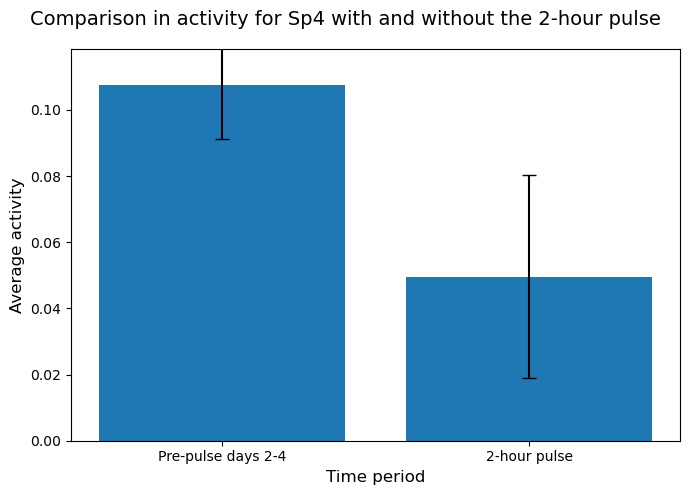

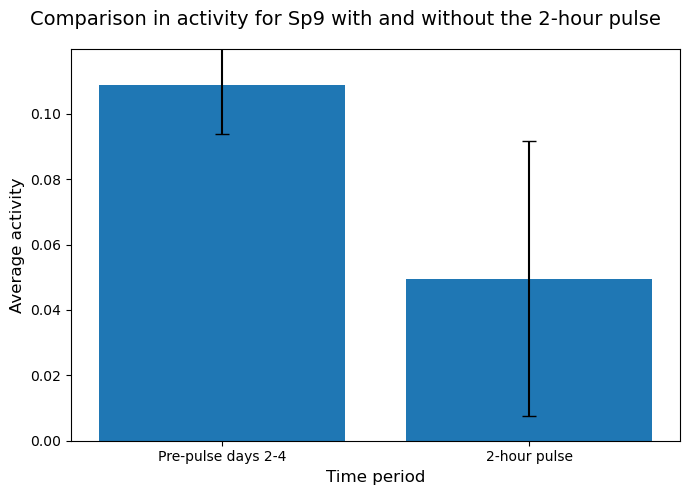

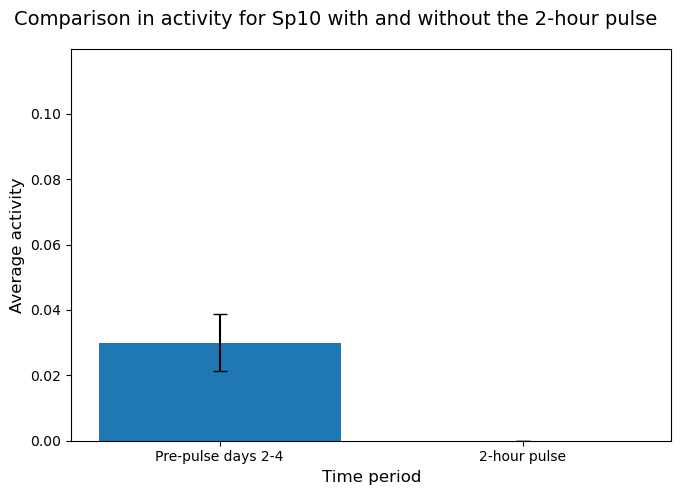

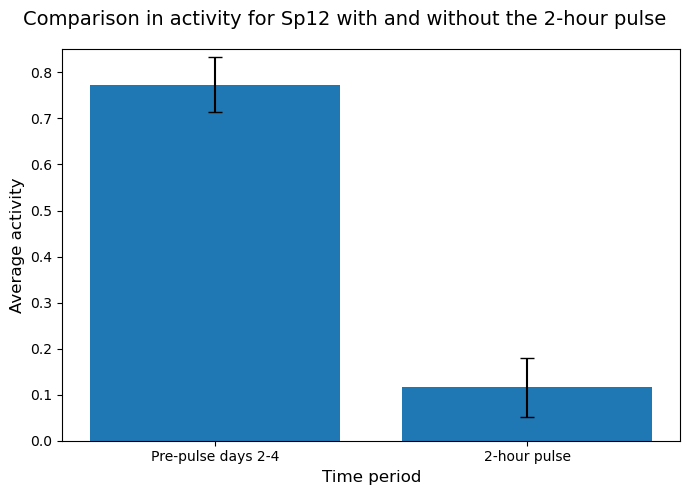

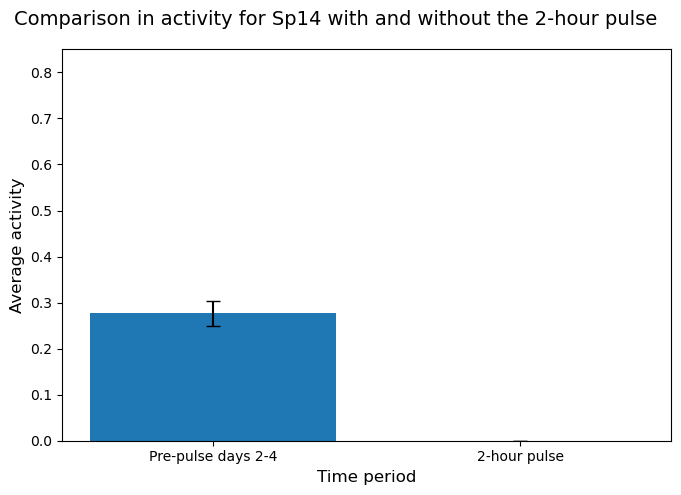

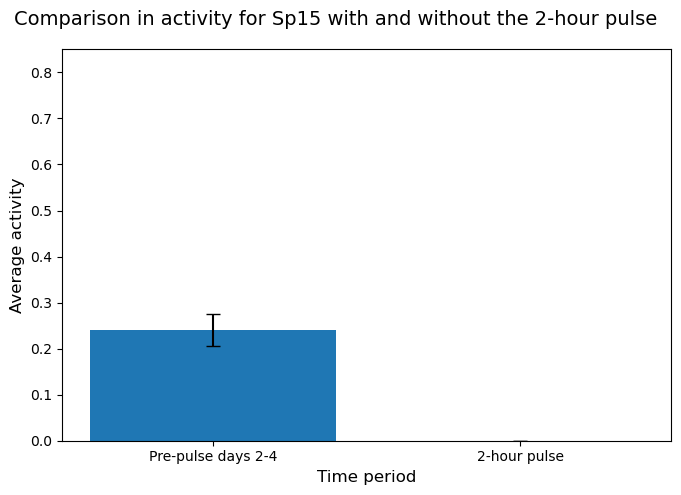

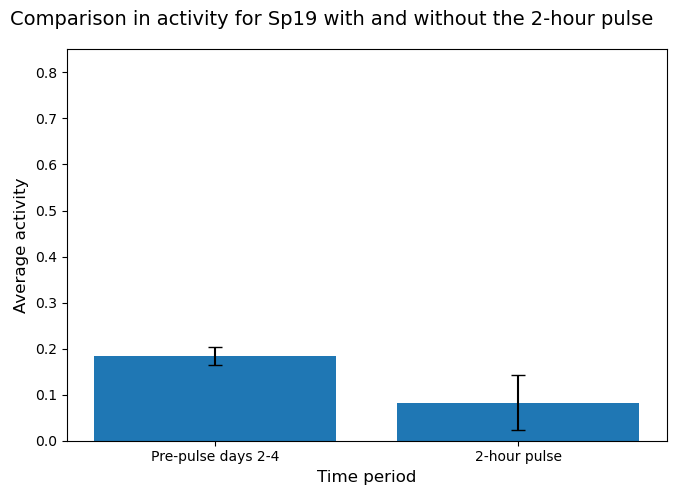

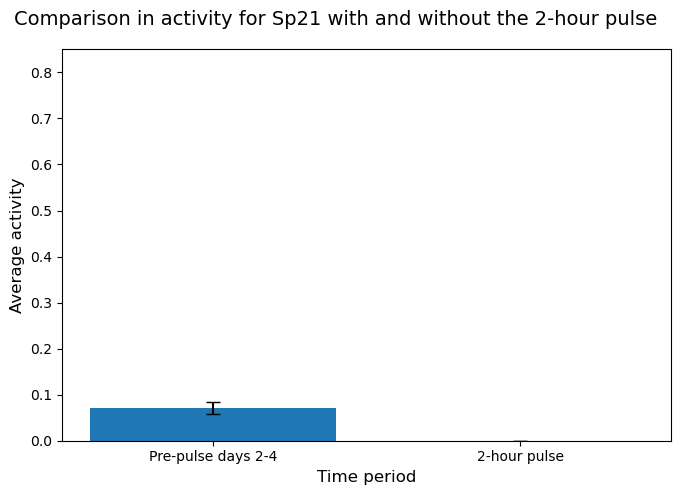

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def filter_and_compare_activity(df, spider_cols, day_pulse, day_pre_pulse, start_hour, end_hour):
    # Define the range of days for the pre-pulse period
    pre_pulse_days = [2, 3, 4]

    # Get the unique dates for the specified days
    pre_pulse_dates = df.loc[df['Day'].isin(pre_pulse_days), 'Time'].dt.date.unique()
    pulse_date = df.loc[df['Day'] == day_pulse, 'Time'].dt.date.unique()[0]
    
    # Construct start and end times with the correct dates
    start_time_pre_pulse = pd.to_datetime(f"{pre_pulse_dates[0]} {start_hour}")
    end_time_pre_pulse = pd.to_datetime(f"{pre_pulse_dates[-1]} {end_hour}")
    start_time_pulse = pd.to_datetime(f"{pulse_date} {start_hour}") 
    end_time_pulse = pd.to_datetime(f"{pulse_date} {end_hour}")
    
    # Filter the days
    days_pre_pulse = df.loc[df['Day'].isin(pre_pulse_days)]
    day_pulse = df.loc[df['Day'] == day_pulse]
    
    # Filter the time range for the specified days
    day_pre_pulse_filtered = days_pre_pulse[(days_pre_pulse['Time'] >= start_time_pre_pulse) & (days_pre_pulse['Time'] <= end_time_pre_pulse)]
    day_pulse_filtered = day_pulse[(day_pulse['Time'] >= start_time_pulse) & (day_pulse['Time'] <= end_time_pulse)]
    
    max_activity = 0  # Initialize maximum activity value
    
    for spider_col in spider_cols:
        # Calculate the mean activity and standard error of the mean for each spider column
        mean_day_pre_pulse = day_pre_pulse_filtered[spider_col].mean()
        mean_day_pulse = day_pulse_filtered[spider_col].mean()
        sem_day_pre_pulse = day_pre_pulse_filtered[spider_col].sem()
        sem_day_pulse = day_pulse_filtered[spider_col].sem()
        max_activity = max(max_activity, mean_day_pre_pulse, mean_day_pulse)  # Update maximum activity
        
        # Plot the results with error bars
        plt.figure(figsize=(7, 5))  # Adjust figsize for better spacing
        plt.bar(['Pre-pulse days 2-4', '2-hour pulse'], [mean_day_pre_pulse, mean_day_pulse],
                    yerr=[sem_day_pre_pulse, sem_day_pulse], capsize=5)
        plt.suptitle(f'Comparison in activity for {spider_col} with and without the 2-hour pulse', fontsize=14)
        plt.ylabel('Average activity', fontsize=12)
        plt.xlabel('Time period', fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout()  # Adjust layout to prevent cutting off labels
            
        plt.ylim(0, max_activity * 1.1)  # Set y-axis limits
        plt.show()
        # Save the plot
        if not os.path.exists("average_activity_pulse"):
            os.makedirs("average_activity_pulse")
        file_path = os.path.join("average_activity_pulse", f"{spider_col}_average_activity_pulse.png")
        plt.savefig(file_path)
        plt.close()

# Example usage
spider_cols = ['Sp4', 'Sp9', 'Sp10', 'Sp12', 'Sp14', 'Sp15', 'Sp19', 'Sp21']
day_pulse = 5 
day_pre_pulse = 4  
start_hour = '16:00:00' 
end_hour = '18:00:00'  

# Ensure 'Time' is in datetime format
merged_df['Time'] = pd.to_datetime(merged_df['Time'])

filter_and_compare_activity(merged_df, spider_cols, day_pulse, day_pre_pulse, start_hour, end_hour)

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def filter_and_compare_activity(df, spider_cols, day_pulse, day_pre_pulse, start_hour, end_hour, save_folder):
    # Create the save folder if it doesn't exist
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    # Define the range of days for the pre-pulse period and after-pulse period
    pre_pulse_days = [2, 3, 4]
    after_pulse_days = [6, 7, 8]

    # Get the unique dates for the specified days
    pre_pulse_dates = df.loc[df['Day'].isin(pre_pulse_days), 'Time'].dt.date.unique()
    pulse_date = df.loc[df['Day'] == day_pulse, 'Time'].dt.date.unique()[0]
    after_pulse_dates = df.loc[df['Day'].isin(after_pulse_days), 'Time'].dt.date.unique()
    
    # Construct start and end times with the correct dates
    start_time_pre_pulse = pd.to_datetime(f"{pre_pulse_dates[0]} {start_hour}")
    end_time_pre_pulse = pd.to_datetime(f"{pre_pulse_dates[-1]} {end_hour}")
    start_time_pulse = pd.to_datetime(f"{pulse_date} {start_hour}")
    end_time_pulse = pd.to_datetime(f"{pulse_date} {end_hour}")
    start_time_after_pulse = pd.to_datetime(f"{after_pulse_dates[0]} {start_hour}")
    end_time_after_pulse = pd.to_datetime(f"{after_pulse_dates[-1]} {end_hour}")

    # Filter the days
    days_pre_pulse = df.loc[df['Day'].isin(pre_pulse_days)]
    day_pulse = df.loc[df['Day'] == day_pulse]
    days_after_pulse = df.loc[df['Day'].isin(after_pulse_days)]
    
    # Filter the time range for the specified days
    day_pre_pulse_filtered = days_pre_pulse[(days_pre_pulse['Time'] >= start_time_pre_pulse) & (days_pre_pulse['Time'] <= end_time_pre_pulse)]
    day_pulse_filtered = day_pulse[(day_pulse['Time'] >= start_time_pulse) & (day_pulse['Time'] <= end_time_pulse)]
    day_after_pulse_filtered = days_after_pulse[(days_after_pulse['Time'] >= start_time_after_pulse) & (days_after_pulse['Time'] <= end_time_after_pulse)]
    
    for spider_col in spider_cols:
        # Calculate the mean activity and standard error of the mean for each spider column
        mean_day_pre_pulse = day_pre_pulse_filtered[spider_col].mean()
        mean_day_pulse = day_pulse_filtered[spider_col].mean()
        mean_day_after_pulse = day_after_pulse_filtered[spider_col].mean()
        sem_day_pre_pulse = day_pre_pulse_filtered[spider_col].sem()
        sem_day_pulse = day_pulse_filtered[spider_col].sem()
        sem_day_after_pulse = day_after_pulse_filtered[spider_col].sem()
        
        # Plot the results with error bars
        plt.figure(figsize=(7, 5))  # Adjust figsize for better spacing
        plt.bar(['Pre-pulse days 2-4', '2-hour pulse', 'After-pulse days 6-8'],
                [mean_day_pre_pulse, mean_day_pulse, mean_day_after_pulse],
                yerr=[sem_day_pre_pulse, sem_day_pulse, sem_day_after_pulse], capsize=5)
        plt.suptitle(f'Comparison in activity for {spider_col} with and without the 2-hour pulse', fontsize=14)
        plt.ylabel('Average activity', fontsize=12)
        plt.xlabel('Time period', fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout()  # Adjust layout to prevent cutting off labels
        
        # Save the plot
        file_path = os.path.join(save_folder, f"{spider_col}_comparison.png")
        plt.savefig(file_path)
        plt.close()

# Example usage
spider_cols = ['Sp4', 'Sp9', 'Sp10', 'Sp12', 'Sp14', 'Sp15', 'Sp19', 'Sp21']
day_pulse = 5 
day_pre_pulse = 4  
start_hour = '16:00:00' 
end_hour = '18:00:00'  
save_folder = 'STB04pm_three_bars'

# Ensure 'Time' is in datetime format
merged_df['Time'] = pd.to_datetime(merged_df['Time'])

filter_and_compare_activity(merged_df, spider_cols, day_pulse, day_pre_pulse, start_hour, end_hour, save_folder)